Holt-Winters (HW) es como frencuentemente se le llaman a los procedimientos
que forman parte de la familia de métodos de pronóstico por suavizamiento
exponencial.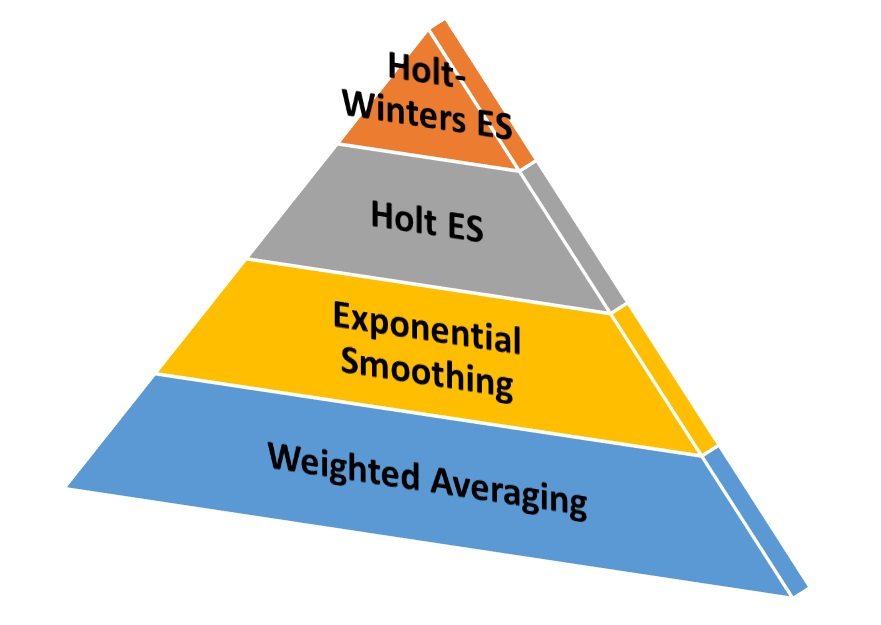








Una de las formas más sencillas de pronósticar un valor, es el promedio de todos los datos de la serie de tiempo.
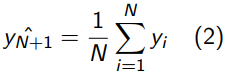
Una mejora es el promedio de los último n datos conocido como media movil.
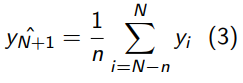
(Palit y otros 2006)





Otra mejora evidente es que las observaciones más recientes tengan mayor influencia en el pronóstico, para ello se usa la media movil ponderada.
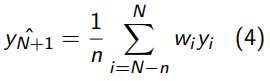

F(t+1)=0.6*F(t)+0.3*F(t-1)+0.1*F(t-2)


La siguiente mejora es el enfoque de suavizamiento exponencial es conveniente para pronóstico de cortos periodos de tiempo, aquí los pesos decaen exponencialmente con la distancia de tiempo de los valores pasados al tiempo actual.
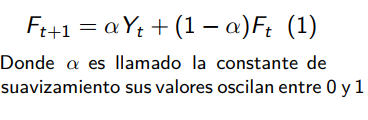
(Svetunkov & Kourentzes 2015)
Para alpha de 0.6..       F(t+1)=0.6*y(t)+(0.4)F(t), F(t)=0.6*y(t-1)+(0.4)F(t-1)


In [41]:
import    os
import    numpy                               as        np
import    pandas                              as        pd
import    matplotlib.pyplot                   as        plt

import    statsmodels.tsa.holtwinters         as        ets
import    statsmodels.tools.eval_measures     as        fa
from      sklearn.metrics                     import    mean_squared_error
from      statsmodels.tsa.holtwinters         import    SimpleExpSmoothing

In [42]:
def     MAPE(y, yhat):
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape = round(np.sum(np.abs(yhat-y))/np.sum(y)*100,2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape    

In [43]:
path = os.path.join('c:' + os.sep, 'Users', 'Christian Galicia', 'Desktop', 'Christian', 'Doctorado', 'HoltWinters', 'Petrol.csv')
petrol_df = pd.read_csv(path)
date_rng  =  pd.date_range(start='1/1/2001', end='30/9/2013', freq='Q')
print(date_rng)

DatetimeIndex(['2001-03-31', '2001-06-30', '2001-09-30', '2001-12-31',
               '2002-03-31', '2002-06-30', '2002-09-30', '2002-12-31',
               '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31',
               '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31',
               '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31',
               '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31',
               '2007-03-31', '2007-06-30', '2007-09-30', '2007-12-31',
               '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30'],
              dtype='datetime64[ns]', freq='Q-DEC')


                               0                    1                    2
Year                        2001                 2001                 2001
Quarter                       Q1                   Q2                   Q3
Consumption               14.978               11.099               10.057
TimeIndex    2001-03-31 00:00:00  2001-06-30 00:00:00  2001-09-30 00:00:00


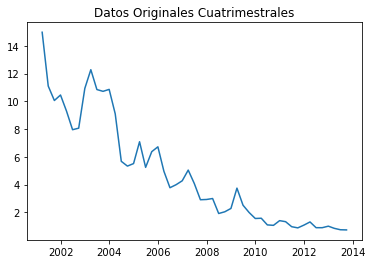

In [44]:
petrol_df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Quarter'])
print(petrol_df.head(3).T)

plt.plot(petrol_df.TimeIndex, petrol_df.Consumption)
plt.title('Datos Originales Cuatrimestrales')
plt.show()

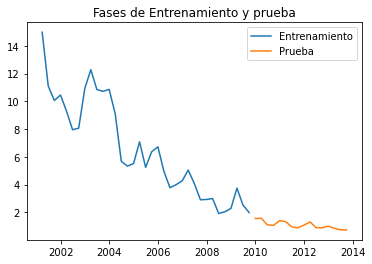

In [45]:
train = petrol_df[0:int(len(petrol_df)*0.7)] 
test= petrol_df[int(len(petrol_df)*0.7):]

plt.plot(train.TimeIndex, train.Consumption, label = 'Entrenamiento')
plt.plot(test.TimeIndex, test.Consumption,  label = 'Prueba')
plt.legend(loc = 'best')
plt.title('Fases de Entrenamiento y prueba')
plt.show()

Trataremos con valores de alpha de 0.2, 0.6 y 0.99 y luego dejaremos que el modelo optimice el valor.
Valores cercanos a 1 indican rápido aprendizaje y solo los valores más recientes tienen influencia en el pronóstico, por el contrario valores cercanos a 0 indican un aprendizaje lento y valores antiguos tienen más influencia en el pronóstico.
— Page 89, Practical Time Series Forecasting with R, 2016.



For alpha = 0.20,  RMSE is 2.007 MAPE is 184.11


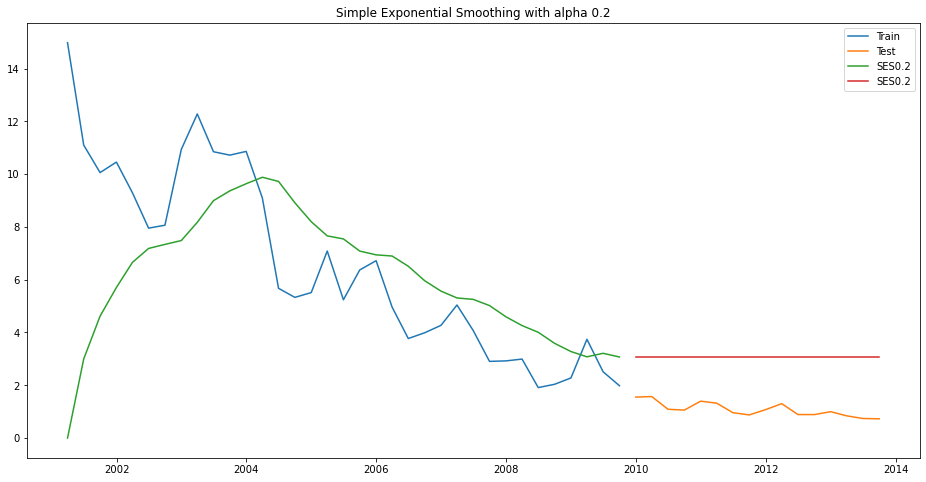

For alpha = 0.60,  RMSE is 1.701 MAPE is 155.54


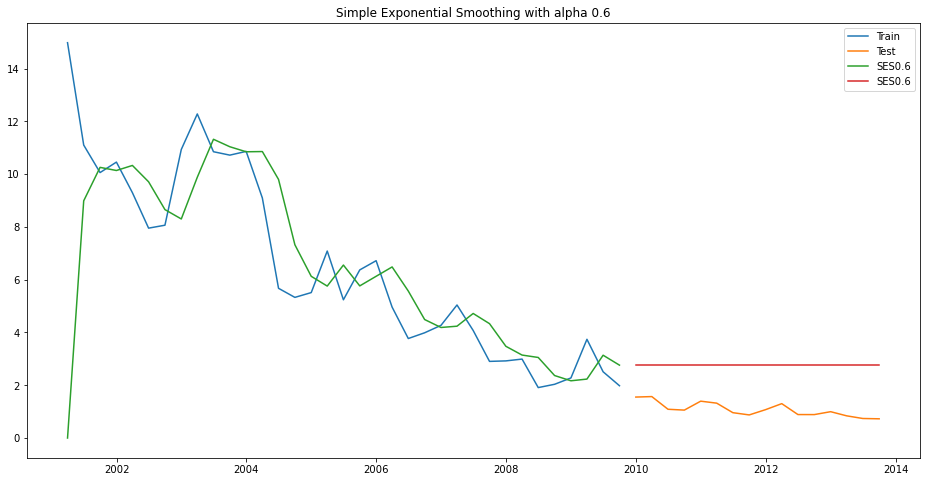

For alpha = 0.99,  RMSE is 1.466 MAPE is 133.44


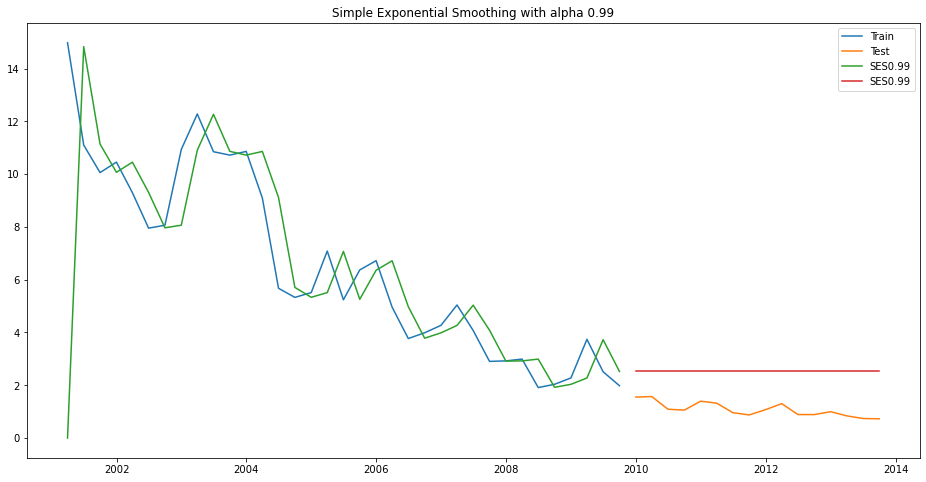

In [46]:
alpha_list = [0.2, 0.6, 0.99]

Train= np.asarray(train['Consumption'])
Test= np.asarray(test['Consumption'])

SES_Train = np.zeros(len(Train))
SES_Test = np.zeros(len(Test))
SES_Train[0] = 0
#SES_Train[0] = Train[0]

for alpha_value in alpha_list:

    alpha_str =  "SES" + str(alpha_value)
    for i in range(len(Train)-1):
        SES_Train[i+1] = alpha_value*Train[i]+(1-alpha_value)*SES_Train[i]
        
    SES_Test[0] = SES_Train[34]
    for ii in range(len(Test)-1):
        SES_Test[ii+1] = alpha_value*SES_Test[ii]+(1-alpha_value)*SES_Test[ii]
        
    
    rmse =  np.sqrt(mean_squared_error(test['Consumption'], SES_Test))
    mape =  MAPE(test['Consumption'], SES_Test)
###
    print("For alpha = %1.2f,  RMSE is %3.3f MAPE is %6.2f" %(alpha_value, rmse, mape))
    plt.figure(figsize=(16,8))
    plt.plot(train.TimeIndex, train['Consumption'], label ='Train')
    plt.plot(test.TimeIndex, test['Consumption'], label  ='Test')
    plt.plot(train.TimeIndex, SES_Train, label  = alpha_str)
    plt.plot(test.TimeIndex, SES_Test, label  = alpha_str)
    plt.title('Simple Exponential Smoothing with alpha ' + str(alpha_value))
    plt.legend(loc='best') 
    plt.show()    

16
[2.8569306  2.15665812 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[2.8569306  2.15665812 2.7168761  2.26870172 2.62724122 2.34040962
 2.5698749  2.38630267 2.53316046 2.41567423 2.50966321 2.43447203
 2.49462497 2.44650262 2.4850005  2.45420219]
    Year Quarter  Consumption  TimeIndex
35  2009      Q4      1.55221 2009-12-31
36  2010      Q1      1.57034 2010-03-31
37  2010      Q2      1.08986 2010-06-30
38  2010      Q3      1.05821 2010-09-30
39  2010      Q4      1.39665 2010-12-31
40  2011      Q1      1.32161 2011-03-31
41  2011      Q2      0.96034 2011-06-30
42  2011      Q3      0.87553 2011-09-30
43  2011      Q4      1.07530 2011-12-31
44  2012      Q1      1.30285 2012-03-31
45  2012      Q2      0.88939 2012-06-30
46  2012      Q3      0.88818 2012-09-30
47  2012      Q4      0.99804 2012-12-31
48  2013      Q1      0.84120 2013-03-31
49  2013      Q2      0.74032 2013-06-

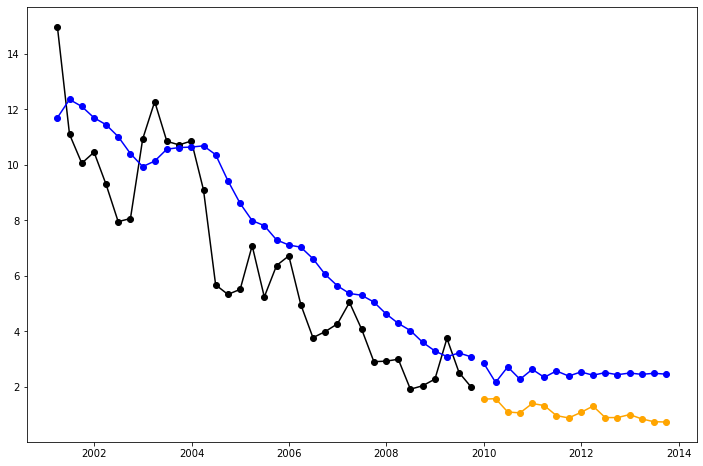

In [47]:
alpha1 = 0.2
fit1 = SimpleExpSmoothing(np.asarray(train['Consumption']), initialization_method="heuristic").fit(smoothing_level=alpha1,optimized=False)
fcast1 = fit1.forecast(len(test['Consumption']))
Train1= np.asarray(train['Consumption'])
Test1= np.asarray(test['Consumption'])
Fcast1 = np.asarray(fcast1)

SES1 = np.zeros(len(Test1))
SES1[0] = Fcast1[0]
SES1[1] = alpha1*Fcast1[0]+(1-alpha1)*Train1[34]
print(len(Test1))
LenSES1 = len(Test1)-2
print(SES1)

for i in range(len(Test1)-2):
    SES1[i+2] = alpha1*SES1[i+1]+(1-alpha1)*SES1[i]


print(SES1)
    
fit2 = SimpleExpSmoothing(np.asarray(train['Consumption']), initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(len(test['Consumption']))
fit3 = SimpleExpSmoothing(np.asarray(train['Consumption']), initialization_method="estimated").fit()
fcast3 = fit3.forecast(len(test['Consumption']))



plt.figure(figsize=(12, 8))

plt.plot(train.TimeIndex, train['Consumption'], marker='o', color='black', label = 'Entrenamiento')
plt.plot(test.TimeIndex, test['Consumption'], marker='o', color='orange', label = 'Entrenamiento')
plt.plot(train.TimeIndex, fit1.fittedvalues, marker='o', color='blue')
plt.plot(test.TimeIndex, SES1, marker='o', color='blue')

print(test)


#plt.plot(train.TimeIndex, fit2.fittedvalues, marker='o', color='red')
#plt.plot(test.TimeIndex, fcast2, marker='o', color='red')
#plt.plot(train.TimeIndex, fit3.fittedvalues, marker='o', color='green')
#plt.plot(test.TimeIndex, fcast3, marker='o', color='green')


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(



== Simple Exponential Smoothing 


Smoothing Level 1.0
Initial Level 14.978

For alpha = 1.00,  RMSE is 0.9386 MAPE is 83.39


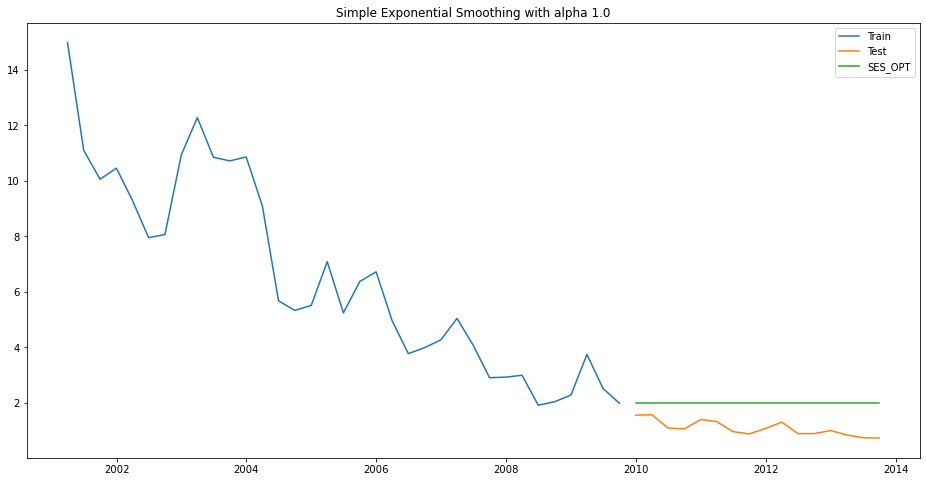

            35       36       37       38       39
Y_hat  1.98159  1.98159  1.98159  1.98159  1.98159
Y      1.55221  1.57034  1.08986  1.05821  1.39665


In [48]:
pred_opt   =  SimpleExpSmoothing(train['Consumption']).fit(optimized = True)
print('')
print('== Simple Exponential Smoothing ')
print('')

print('')
print('Smoothing Level', np.round(pred_opt.params['smoothing_level'], 4))
print('Initial Level',   np.round(pred_opt.params['initial_level'], 4))
print('')

y_pred_opt           = pred_opt.forecast(steps = 16)
df_pred_opt          = pd.DataFrame({'Y_hat':y_pred_opt,'Y':test['Consumption'].values})

rmse_opt             =  np.sqrt(mean_squared_error(test['Consumption'], y_pred_opt))
mape_opt             =  MAPE(test['Consumption'], y_pred_opt)

alpha_value          = np.round(pred_opt.params['smoothing_level'], 4)

print("For alpha = %1.2f,  RMSE is %3.4f MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))

plt.figure(figsize=(16,8))
plt.plot(train.TimeIndex, train['Consumption'], label = 'Train')
plt.plot(test.TimeIndex, test['Consumption'],  label = 'Test')
plt.plot(test.TimeIndex, y_pred_opt,           label = 'SES_OPT')
plt.title('Simple Exponential Smoothing with alpha ' + str(alpha_value))
plt.legend(loc='best') 
plt.show()

print(df_pred_opt.head().T)


Puntos Importantes.
1. Pronostica el siguiente valor con una ponderación de medias que decaen exponencialmente.
2. Los algoritmos de HW solo producen el pronóstico de un paso adelante. [5] [Hyndman entre otros, 2008]
3. No recomendado cuando la serie de tiempo exhibe tendencia y estacionalidad.

Doble Suavizado Exponencial.
El SSE no detecta la presencia de la tendencia, normalmente se utiliza un alpha de 0.1 a 0.3 pues el de 1 es igual a la última observación, este se aplica cuando los datos tienen tendencia.
Se consideran dos componentes separados:
Nivel:        alpha es la media local.
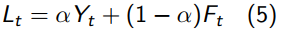



Tendencia:    beta para capturar la tendencia de la serie.
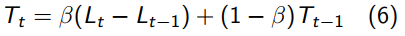



El pronóstico en el tiempo t+eta sería:

(Palit y otros 2006)

For alpha = 0.20 and beta = 0.99, RMSE is 4.542 MAPE is 373.71


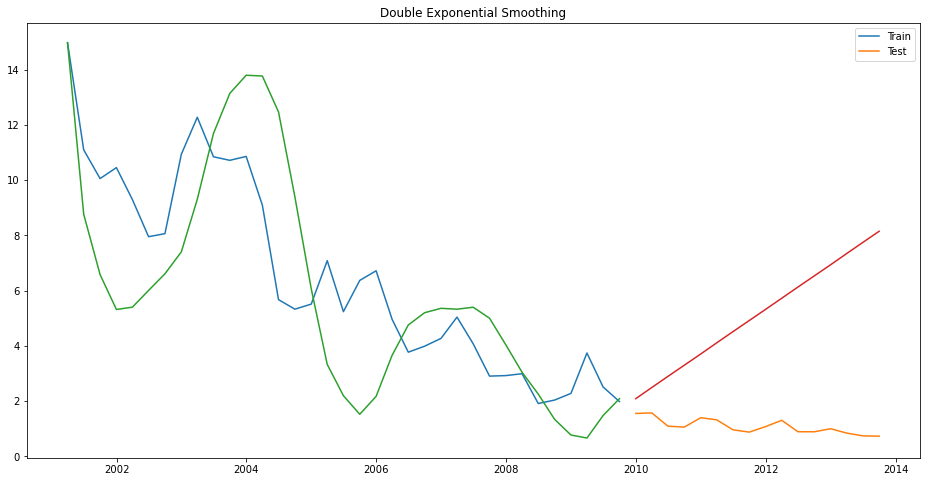

For alpha = 0.60 and beta = 0.99, RMSE is 2.882 MAPE is 260.58


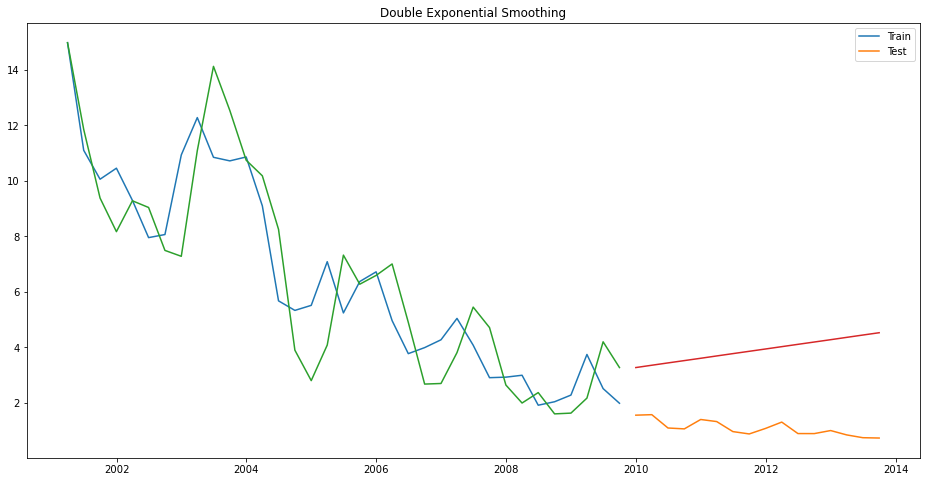

For alpha = 0.99 and beta = 0.99, RMSE is 9.899 MAPE is 781.68


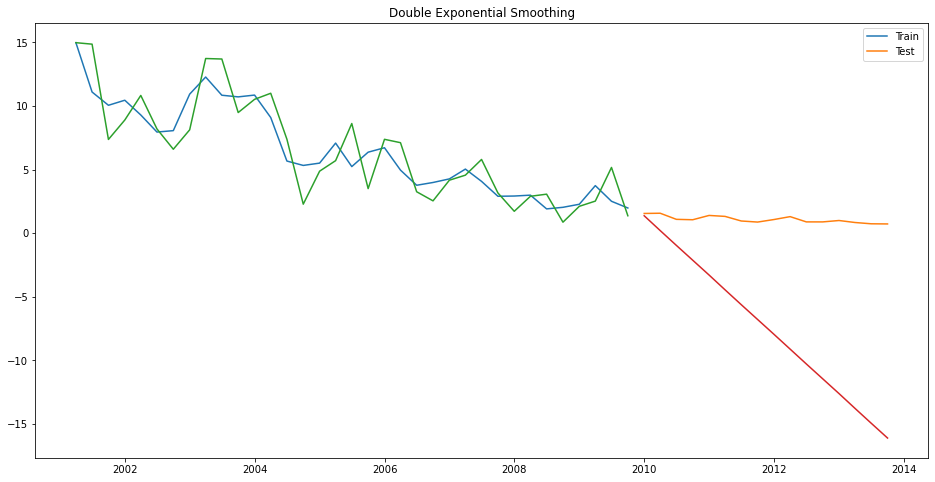

For alpha = 0.20 and beta = 0.60, RMSE is 0.533 MAPE is  42.21


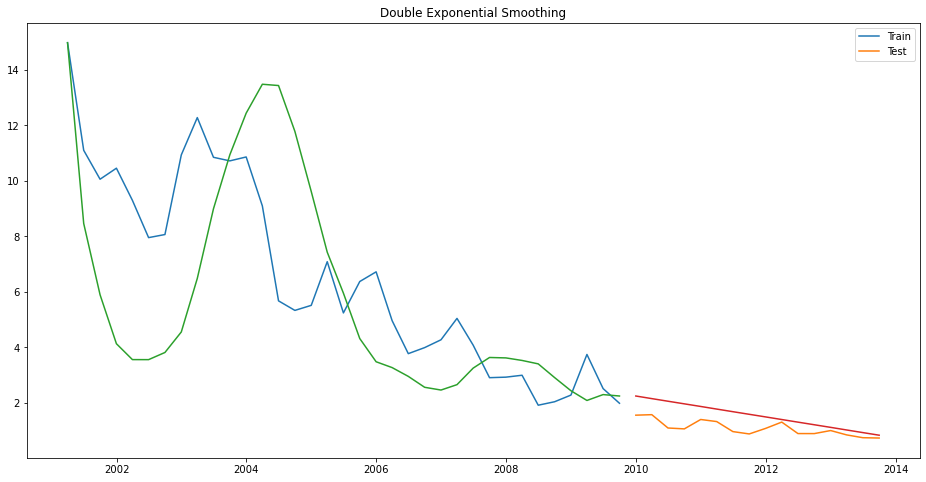

For alpha = 0.60 and beta = 0.60, RMSE is 3.716 MAPE is 327.51


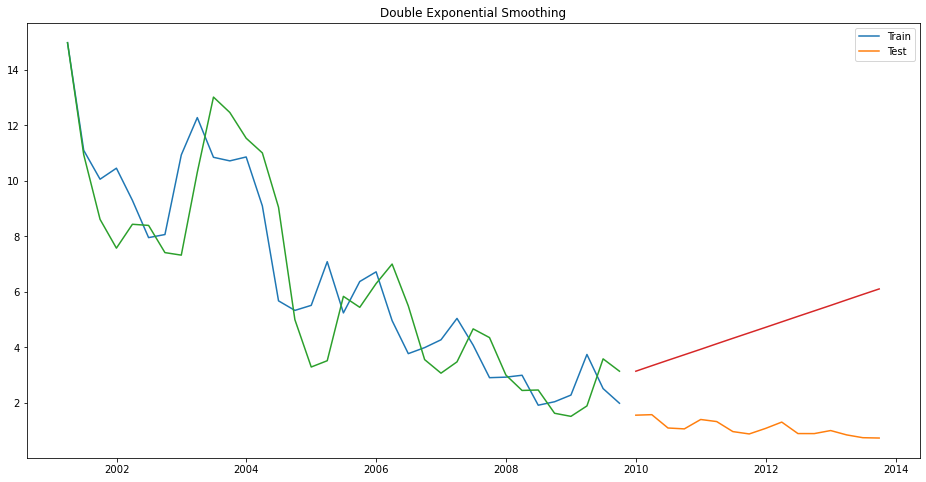

For alpha = 0.99 and beta = 0.60, RMSE is 2.150 MAPE is 161.89


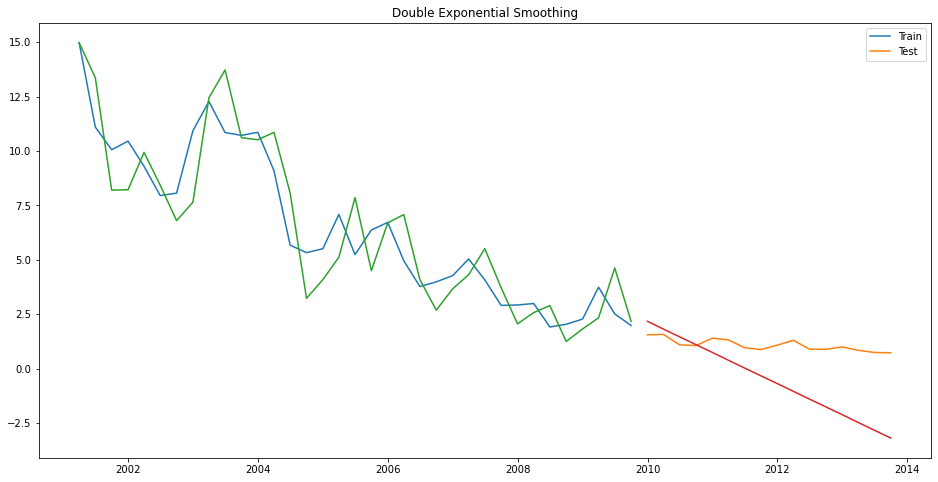

For alpha = 0.20 and beta = 0.20, RMSE is 1.403 MAPE is 105.06


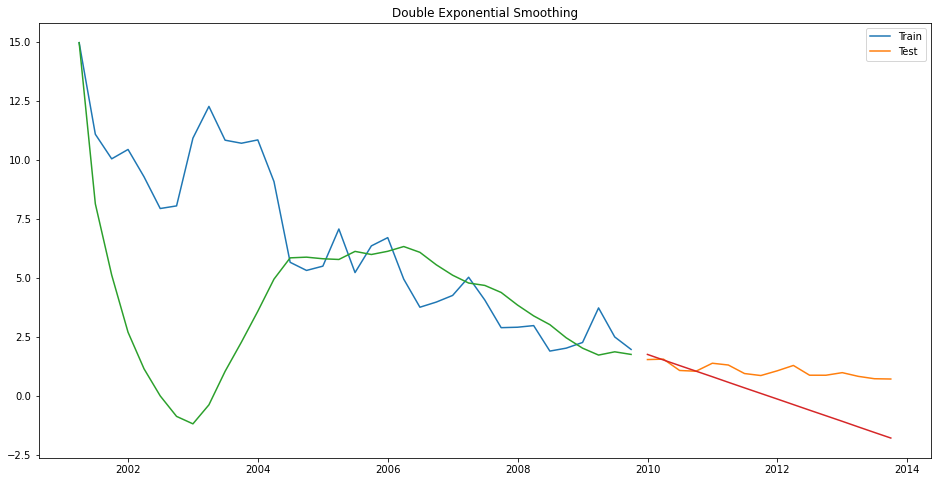

For alpha = 0.60 and beta = 0.20, RMSE is 1.021 MAPE is  92.81


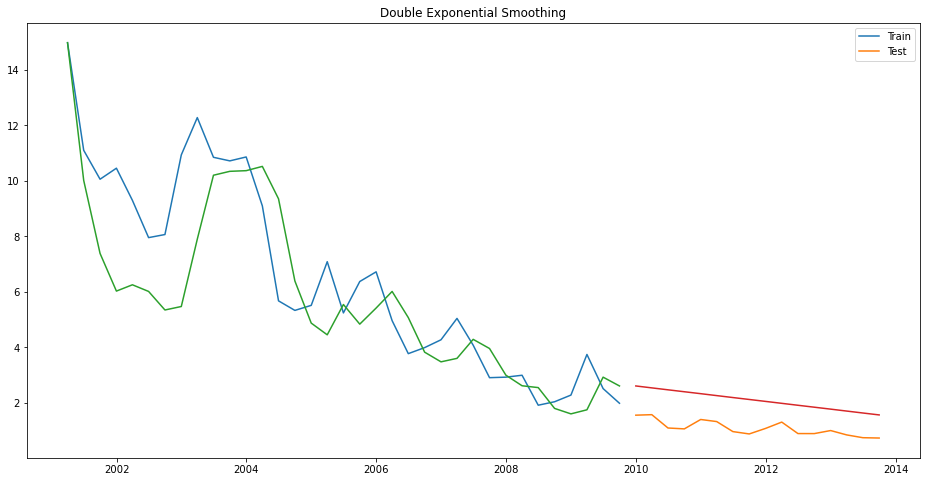

For alpha = 0.99 and beta = 0.20, RMSE is 0.528 MAPE is  41.46


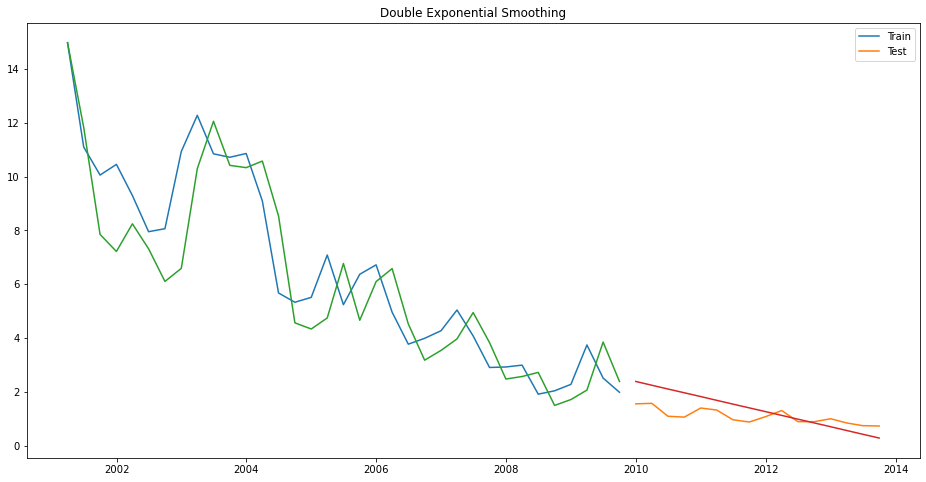

In [49]:
alpha_list = [0.2, 0.6, 0.99]
beta_list = [0.99, 0.6, 0.2]

Train= np.asarray(train['Consumption'])
Test= np.asarray(test['Consumption'])

DES_Train = np.zeros(len(Train))
DES_Test = np.zeros(len(Test))
L = np.zeros(len(Train))
LT = np.zeros(len(Test))
T = np.zeros(len(Train))
TT = np.zeros(len(Test))

#DES_Train[0] = 0
DES_Train[0] = Train[0]
L[0] = Train[0]
T[0] = Train[1] - Train[0]

for beta_value in beta_list:

    for alpha_value in alpha_list:

        alpha_str =  "DES" + str(alpha_value)
        beta_str =  "DES" + str(beta_value)
        for i in range(len(Train)-1):
            L[i+1] = alpha_value*Train[i] + (1-alpha_value)*(L[i]+T[i])
            T[i+1] = beta_value*(L[i+1]-L[i])+(1-beta_value)*T[i]
            DES_Train[i+1] = L[i+1]+T[i+1]

        DES_Test[0] = DES_Train[34]
        LT[0] = L[34]
        TT[0] = T[34]
        for ii in range(len(Test)-1):
            LT[ii+1] = alpha_value*DES_Test[ii]+(1-alpha_value)*(LT[ii]+TT[ii])            
            TT[ii+1] = beta_value*(LT[ii+1]-LT[ii])+(1 - beta_value)*TT[ii]
            DES_Test[ii+1] = LT[ii+1]+TT[ii+1]


        rmse =  np.sqrt(mean_squared_error(test['Consumption'], DES_Test))
        mape =  MAPE(test['Consumption'], DES_Test)
        ###
        print("For alpha = %1.2f and beta = %1.2f, RMSE is %3.3f MAPE is %6.2f" %(alpha_value, beta_value, rmse, mape))
        plt.figure(figsize=(16,8))
        plt.plot(train.TimeIndex, train['Consumption'], label ='Train')
        plt.plot(test.TimeIndex, test['Consumption'], label  ='Test')
        plt.plot(train.TimeIndex, DES_Train)
        plt.plot(test.TimeIndex, DES_Test)
        plt.title('Double Exponential Smoothing')
        plt.legend(loc='best') 
        plt.show()    

In [50]:
from   statsmodels.tsa.holtwinters import  Holt
model = Holt(np.asarray(train['Consumption']))

# Si no se definen se calculan solos alpha y beta
model_fit = model.fit()
# Definimos valores de alpha y beta
#model_fit = model.fit(smoothing_level = 0.8, smoothing_trend = 0.2, optimized=False)

print('')
print('==Holt model Exponential Smoothing Parameters ==')
print('')
alpha_value = np.round(model_fit.params['smoothing_level'], 4)
print('alpha', alpha_value )
#print(model_fit.params)
beta_value = np.round(model_fit.params['smoothing_trend'], 4)
print('beta', beta_value)
print('Initial Level',   np.round(model_fit.params['initial_level'], 4))
print('')


==Holt model Exponential Smoothing Parameters ==

alpha 1.0
beta 0.0
Initial Level 15.3602



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [51]:
Pred_Holt = test.copy()

Pred_Holt['Opt'] = model_fit.forecast(len(test['Consumption']))

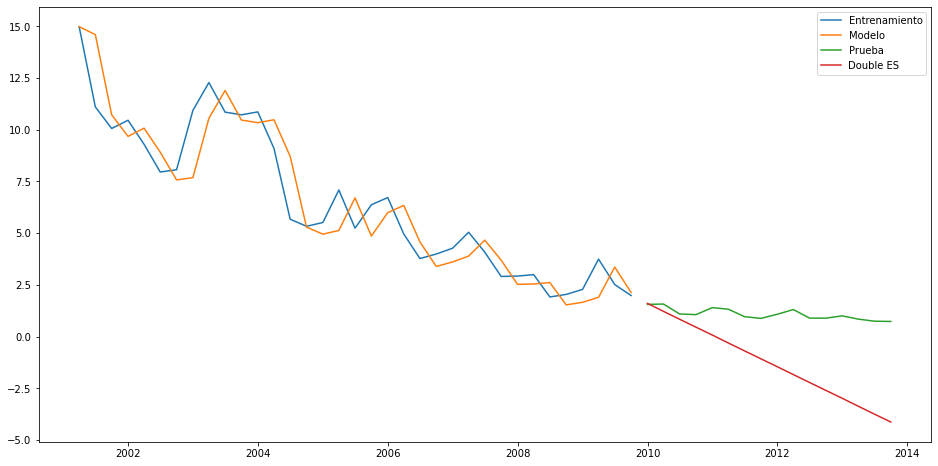

In [52]:
plt.figure(figsize=(16,8))
plt.plot(train.TimeIndex, train['Consumption'], label='Entrenamiento')
plt.plot(train.TimeIndex, model_fit.fittedvalues, label='Modelo')
plt.plot(test.TimeIndex, test['Consumption'], label='Prueba')
plt.plot(test.TimeIndex, Pred_Holt['Opt'], label='Double ES')
plt.legend(loc='best')
plt.show()

In [53]:
df_pred_opt =  pd.DataFrame({'Y_hat':Pred_Holt['Opt'] ,'Y':test['Consumption'].values})
rmse_opt =  np.sqrt(mean_squared_error(df_pred_opt.Y, df_pred_opt.Y_hat))
mape_opt =  MAPE(df_pred_opt.Y, df_pred_opt.Y_hat)
print(model_fit.params)

print("Para alpha = %1.2f, para beta = %1.2f,  RMSE de %3.4f y MAPE de %3.2f" %(alpha_value, beta_value, rmse_opt, mape_opt))

{'smoothing_level': 0.9999999850986383, 'smoothing_trend': 2.1376917800136138e-14, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 15.360248439248064, 'initial_trend': -0.3822396195925707, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
Para alpha = 1.00, para beta = 0.00,  RMSE de 2.8192 y MAPE de 217.85


Para el Doble Suavizado Exponencial Multiplicativo basta con hacer una pequeña modificación en las ecuaciones, para ello se muestran las ecuaciones aditivas y luego las multiplicativas.
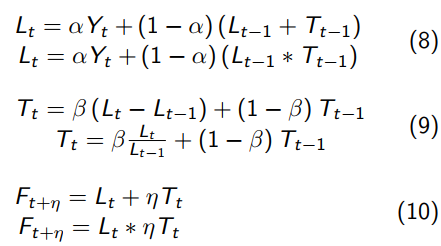
(Palit y otros 2006)

For alpha = 0.20 and beta = 0.80, RMSE is 2.569 MAPE is 219.96


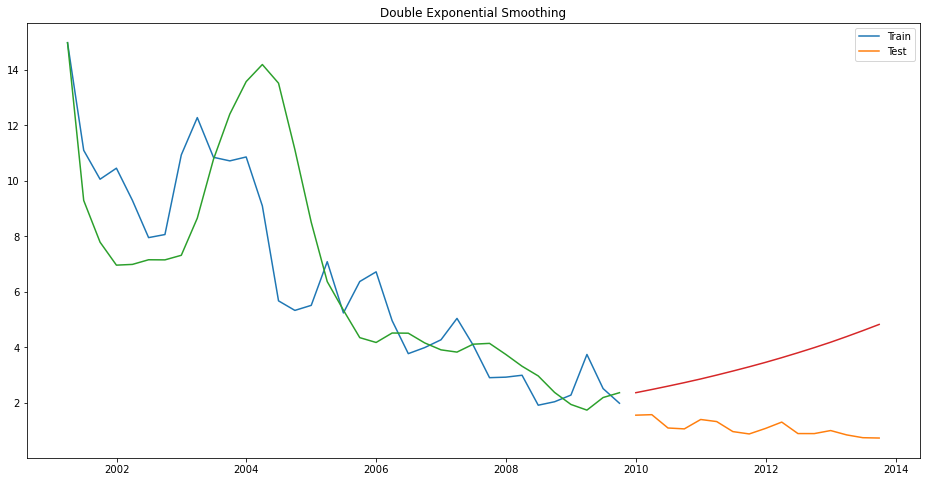

For alpha = 0.60 and beta = 0.80, RMSE is 10.953 MAPE is 861.88


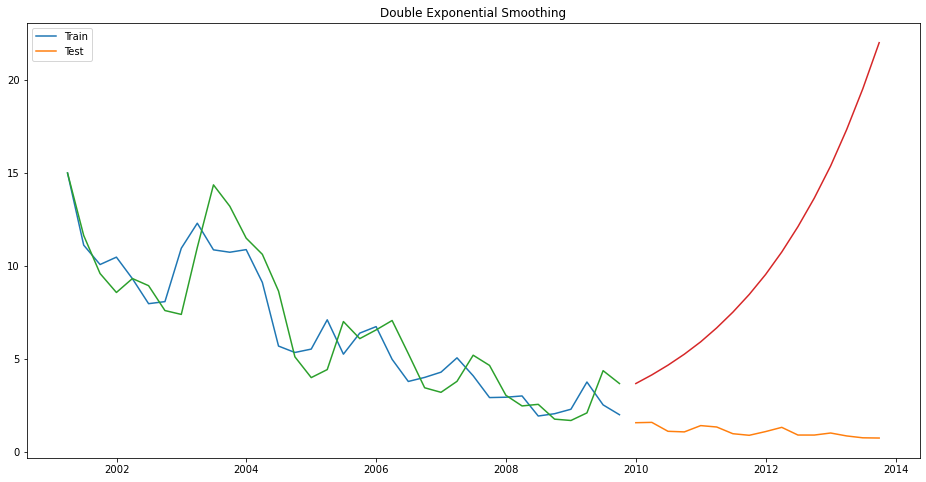

For alpha = 0.99 and beta = 0.80, RMSE is 0.479 MAPE is  41.09


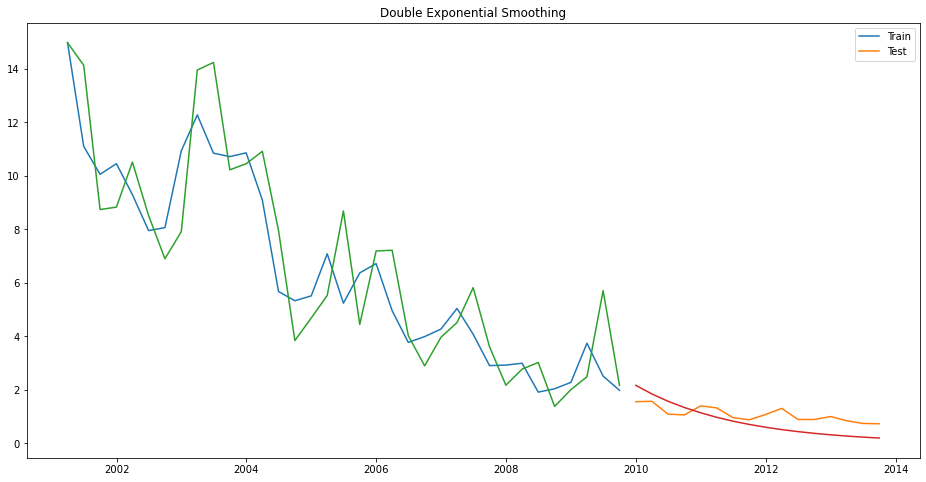

For alpha = 0.20 and beta = 0.60, RMSE is 1.361 MAPE is 122.86


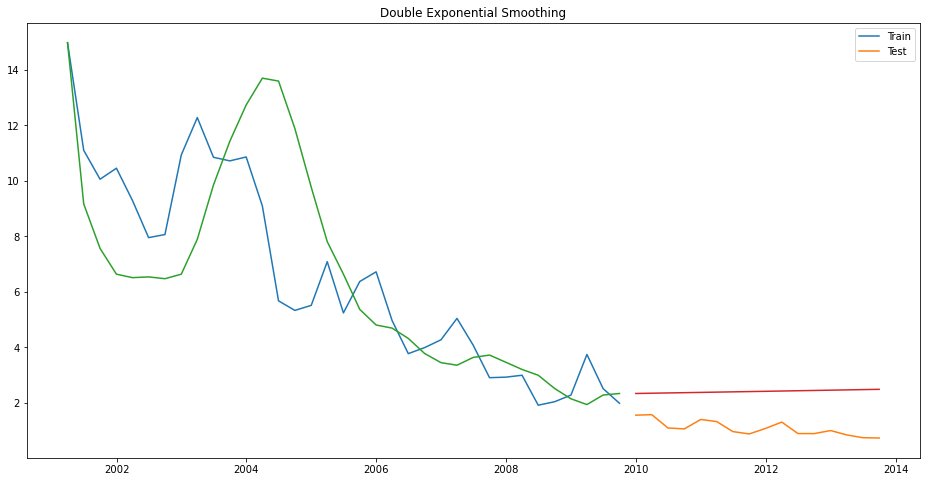

For alpha = 0.60 and beta = 0.60, RMSE is 9.392 MAPE is 745.37


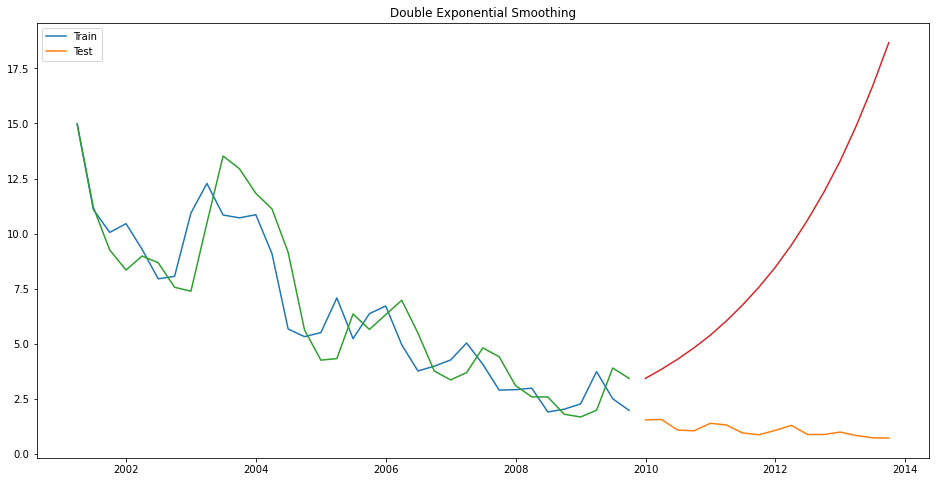

For alpha = 0.99 and beta = 0.60, RMSE is 0.914 MAPE is  83.10


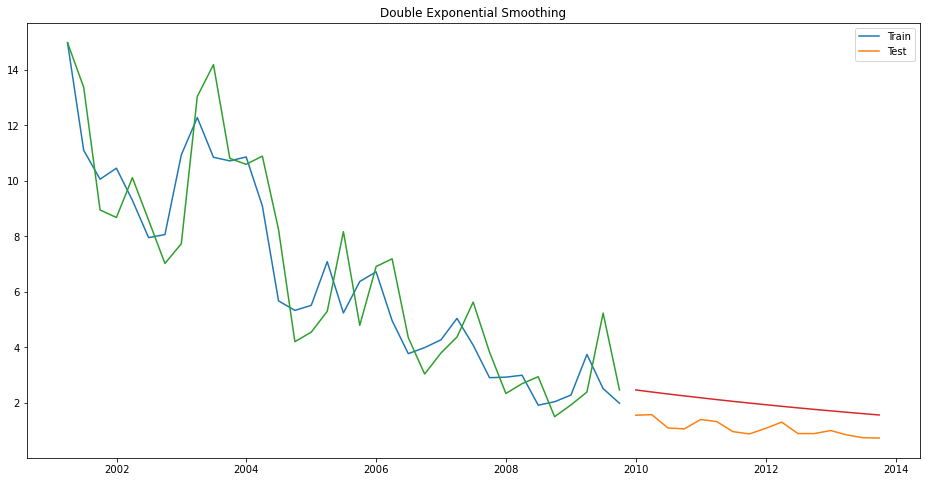

For alpha = 0.20 and beta = 0.20, RMSE is 0.475 MAPE is  39.07


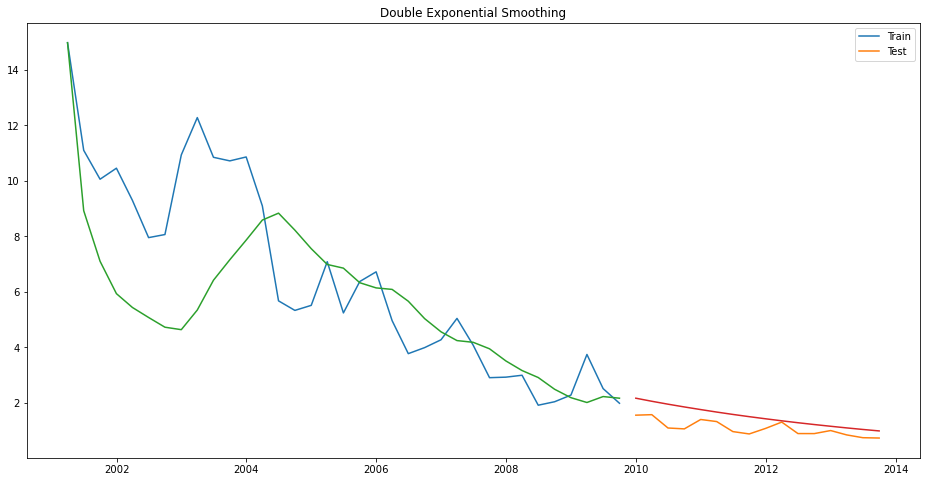

For alpha = 0.60 and beta = 0.20, RMSE is 1.879 MAPE is 170.95


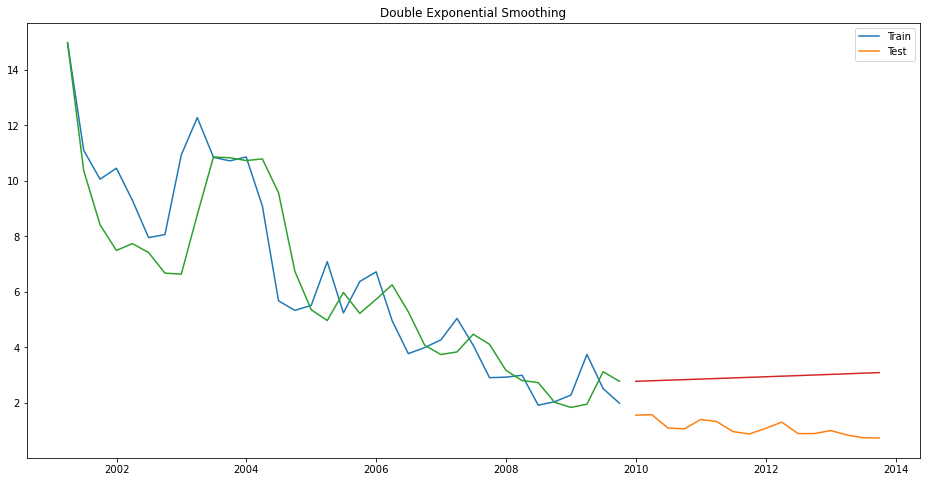

For alpha = 0.99 and beta = 0.20, RMSE is 1.835 MAPE is 165.08


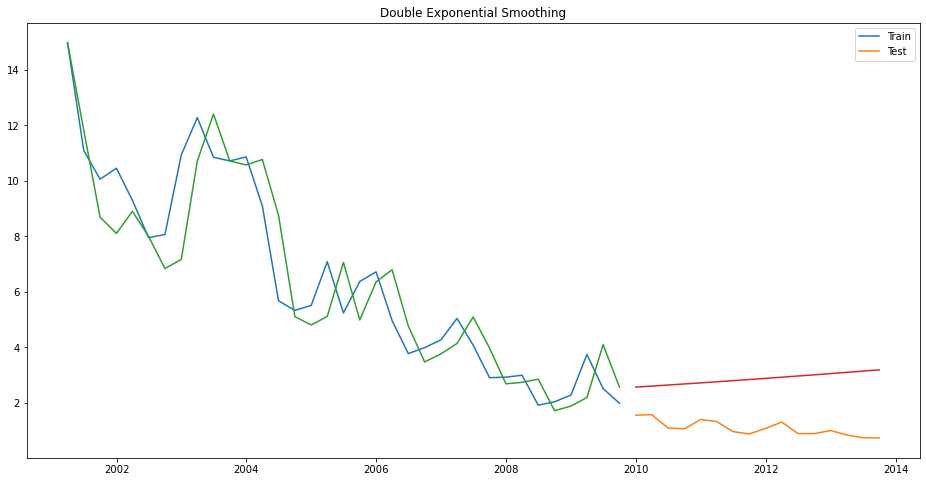

For alpha = 0.20 and beta = 0.05, RMSE is 0.258 MAPE is  20.67


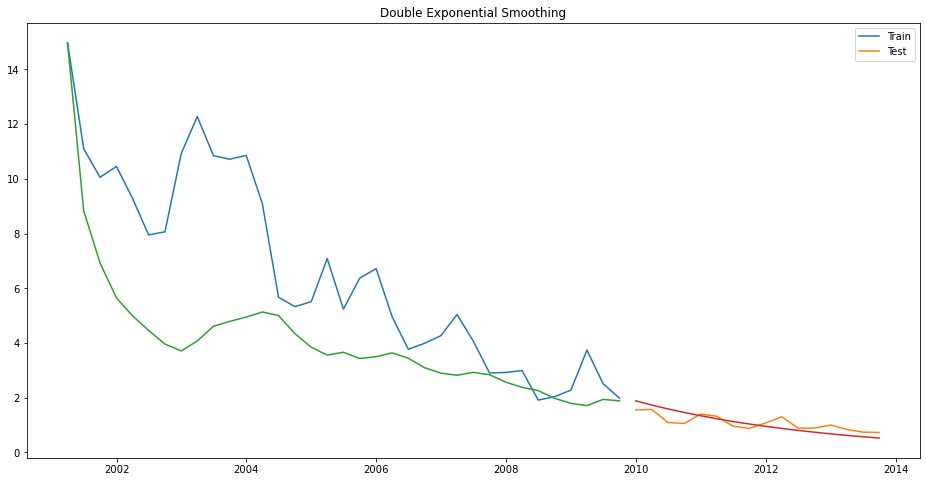

For alpha = 0.60 and beta = 0.05, RMSE is 0.518 MAPE is  37.67


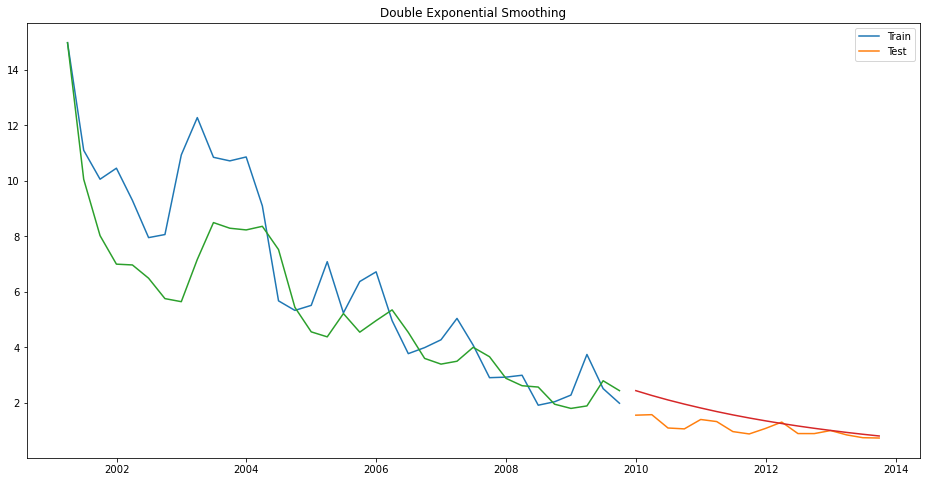

For alpha = 0.99 and beta = 0.05, RMSE is 0.533 MAPE is  41.89


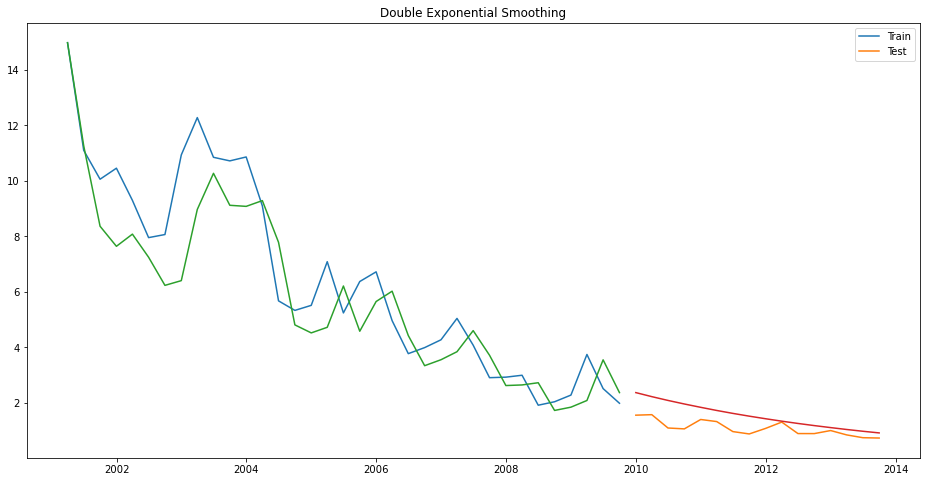

In [54]:
alpha_list = [0.2, 0.6, 0.99]
beta_list = [0.8, 0.6, 0.2, 0.05]

Train= np.asarray(train['Consumption'])
Test= np.asarray(test['Consumption'])

DES_Train = np.zeros(len(Train))
DES_Test = np.zeros(len(Test))
L = np.zeros(len(Train))
LT = np.zeros(len(Test))
T = np.zeros(len(Train))
TT = np.zeros(len(Test))

#DES_Train[0] = 0
DES_Train[0] = Train[0]
L[0] = Train[0]
T[0] = Train[1] / Train[0]

for beta_value in beta_list:

    for alpha_value in alpha_list:

        alpha_str =  "DES" + str(alpha_value)
        beta_str =  "DES" + str(beta_value)
        for i in range(len(Train)-1):
            L[i+1] = alpha_value*Train[i] + (1-alpha_value)*(L[i]*T[i])
            T[i+1] = beta_value*(L[i+1]/L[i]) + (1-beta_value)*T[i]
            DES_Train[i+1] = L[i+1]*T[i+1]

        DES_Test[0] = DES_Train[34]
        LT[0] = L[34]
        TT[0] = T[34]
        for ii in range(len(Test)-1):
            LT[ii+1] = alpha_value*DES_Test[ii]+(1-alpha_value)*(LT[ii]*TT[ii])            
            TT[ii+1] = beta_value*(LT[ii+1]/LT[ii])+(1 - beta_value)*TT[ii]
            DES_Test[ii+1] = LT[ii+1]*TT[ii+1]


        rmse =  np.sqrt(mean_squared_error(test['Consumption'], DES_Test))
        mape =  MAPE(test['Consumption'], DES_Test)
        ###
        print("For alpha = %1.2f and beta = %1.2f, RMSE is %3.3f MAPE is %6.2f" %(alpha_value, beta_value, rmse, mape))
        plt.figure(figsize=(16,8))
        plt.plot(train.TimeIndex, train['Consumption'], label ='Train')
        plt.plot(test.TimeIndex, test['Consumption'], label  ='Test')
        plt.plot(train.TimeIndex, DES_Train)
        plt.plot(test.TimeIndex, DES_Test)
        plt.title('Double Exponential Smoothing')
        plt.legend(loc='best') 
        plt.show()    

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


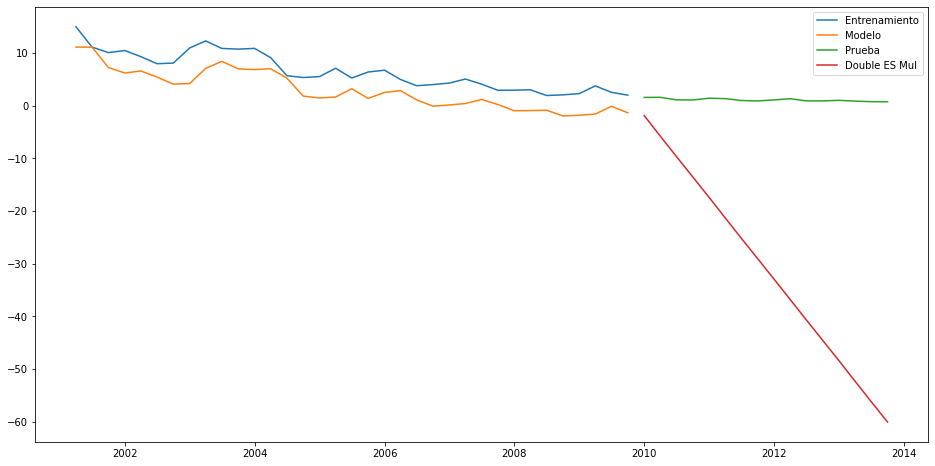

Para alpha = 1.00, para beta = 0.00,  RMSE de 36.6173 y MAPE de 2968.07


In [55]:
from   statsmodels.tsa.holtwinters import  Holt
modelM = Holt(np.asarray(train['Consumption']))

# Definimos valores de alpha y beta
alpha_mul = 0.9999999850986383
beta_mul = 2.1376917800136138e-14

modelM_fit = modelM.fit(smoothing_level = alpha_mul, smoothing_trend = beta_mul, optimized=False)
#modelM_fit = modelM.fit(smoothing_level = alpha_mul, smoothing_trend = beta_mul, optimized=False)

Pred_Holt_M = test.copy()
Pred_Holt_M['Opt'] = modelM_fit.forecast(len(test['Consumption']))

plt.figure(figsize=(16,8))
plt.plot(train.TimeIndex, train['Consumption'], label='Entrenamiento')
plt.plot(train.TimeIndex, modelM_fit.fittedvalues, label='Modelo')
plt.plot(test.TimeIndex, test['Consumption'], label='Prueba')
plt.plot(test.TimeIndex, Pred_Holt_M['Opt'], label='Double ES Mul')
plt.legend(loc='best')
plt.show()

df_pred_opt1 =  pd.DataFrame({'Y_hat':Pred_Holt_M['Opt'] ,'Y':test['Consumption'].values})
rmse_opt =  np.sqrt(mean_squared_error(df_pred_opt1.Y, df_pred_opt1.Y_hat))
mape_opt =  MAPE(df_pred_opt1.Y, df_pred_opt1.Y_hat)

print("Para alpha = %1.2f, para beta = %1.2f,  RMSE de %3.4f y MAPE de %3.2f" %(alpha_mul, beta_mul, rmse_opt, mape_opt))


Puntos Importantes. Double Exponential Smoothing.
1. Bueno para series de tiempo con tendencia y falla cuando la serie presenta estacionalidad.
2. Al igual que SES, DES es solo para pronósticar un paso adelante.
2. El aprendizaje de la tendencia tiende a ser muy pequeño a diferencia de alpha.
(DeLivera2011)

Doble Suavizado Exponencial con tendencia amortiguada. DES tiende a sobre estimar debido a la extrapolación de la tendencia como describe [Gadner and McKenzie (1985)] y aquí mismo se describe la inclusión del parámetro de amortiguado phi.
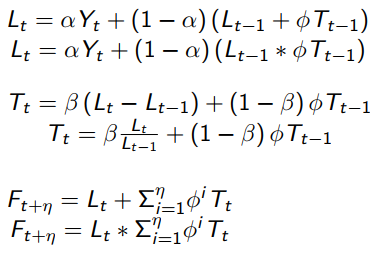


For alpha = 0.20, beta = 0.80 and phi =0.00, RMSE is 2.014 MAPE is 184.81


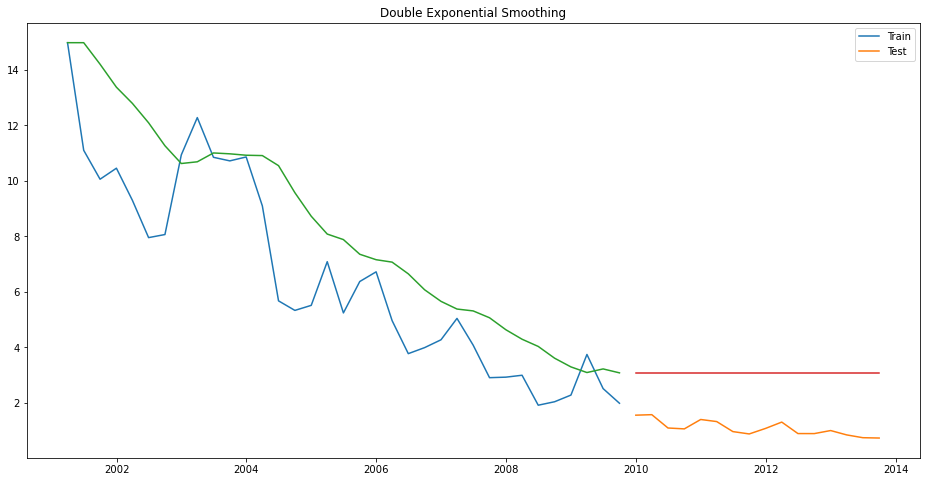

For alpha = 0.20, beta = 0.80 and phi =0.30, RMSE is 1.777 MAPE is 162.68


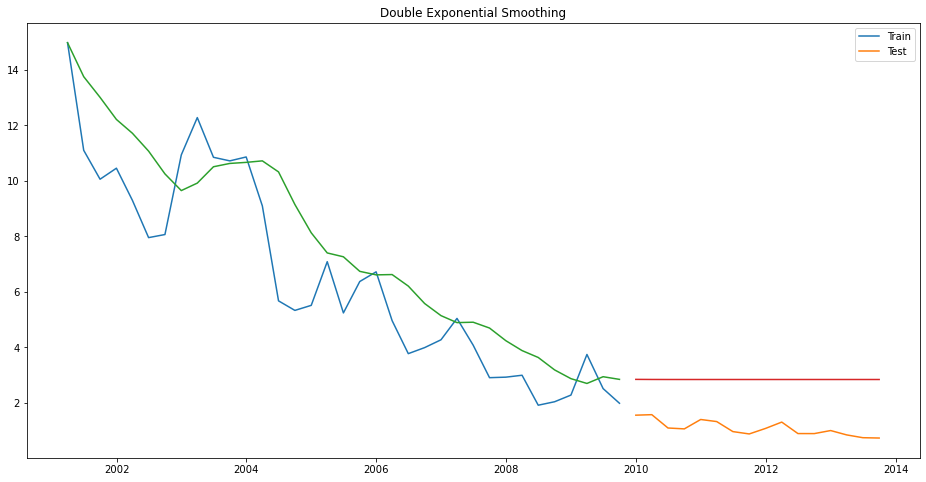

For alpha = 0.20, beta = 0.80 and phi =0.60, RMSE is 1.596 MAPE is 145.56


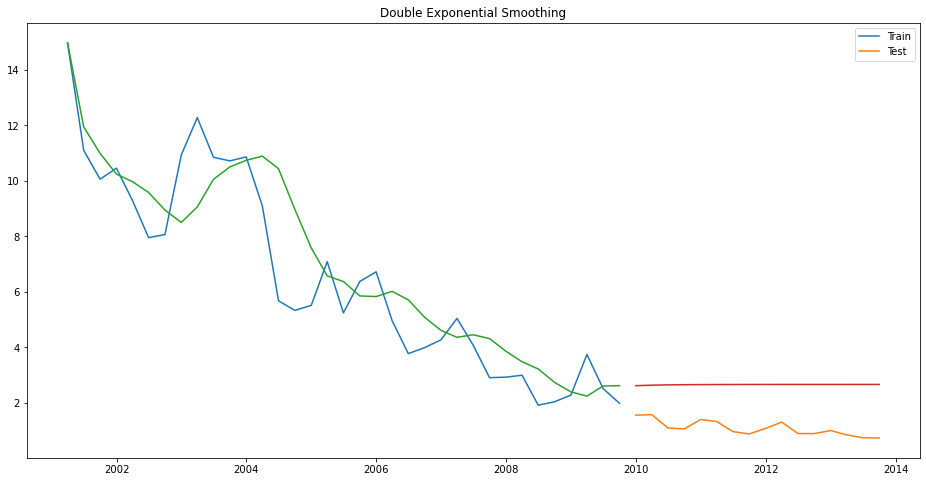

For alpha = 0.20, beta = 0.80 and phi =0.90, RMSE is 1.553 MAPE is 138.33


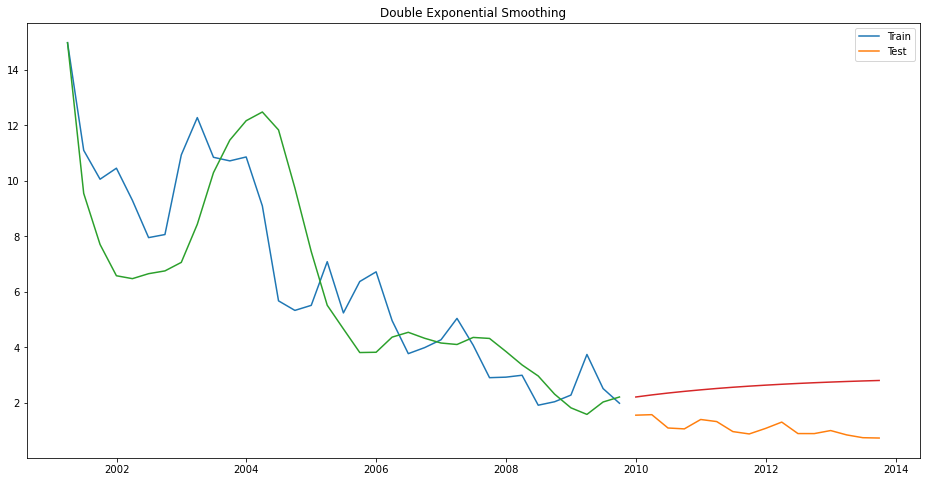

For alpha = 0.20, beta = 0.80 and phi =1.00, RMSE is 0.518 MAPE is  43.55


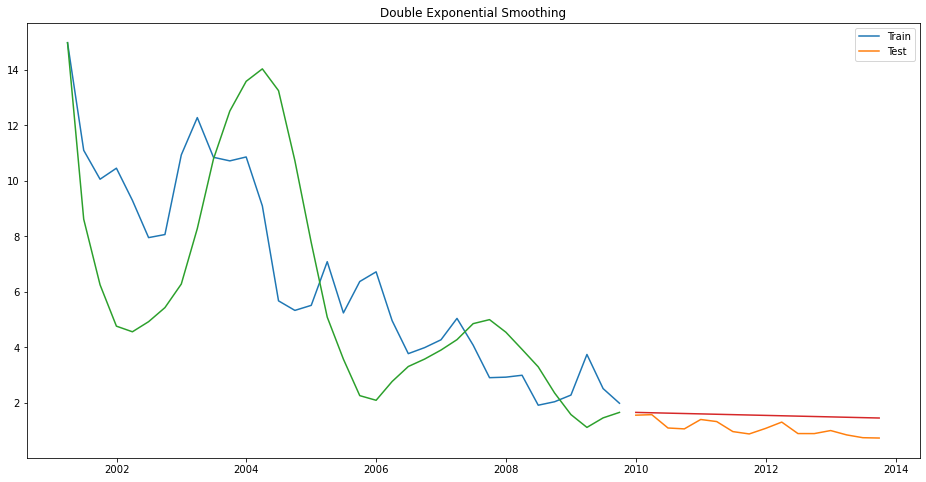

For alpha = 0.20, beta = 0.80 and phi =1.20, RMSE is 138.180 MAPE is 9493.98


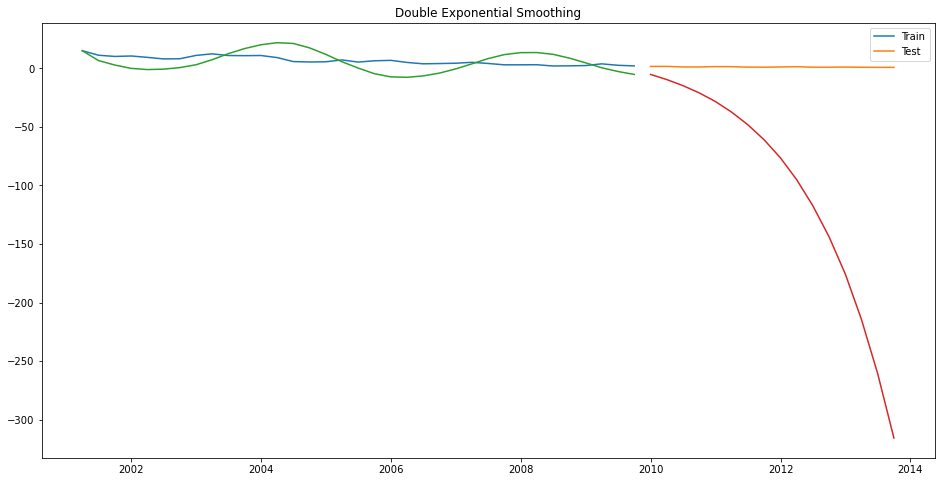

For alpha = 0.60, beta = 0.80 and phi =0.00, RMSE is 1.701 MAPE is 155.54


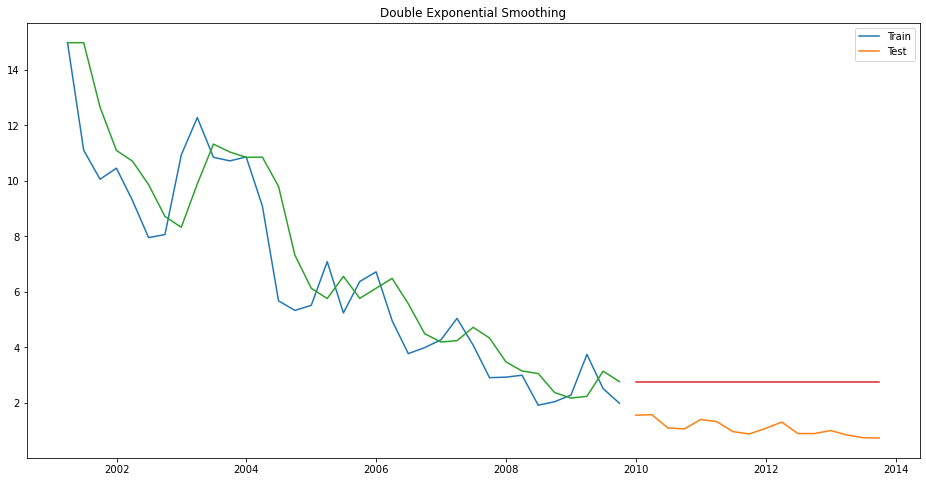

For alpha = 0.60, beta = 0.80 and phi =0.30, RMSE is 1.712 MAPE is 156.62


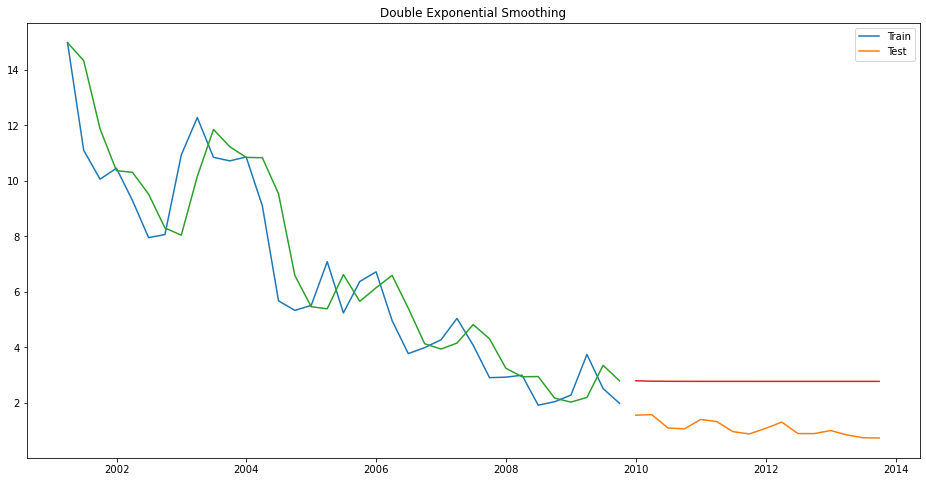

For alpha = 0.60, beta = 0.80 and phi =0.60, RMSE is 1.831 MAPE is 167.79


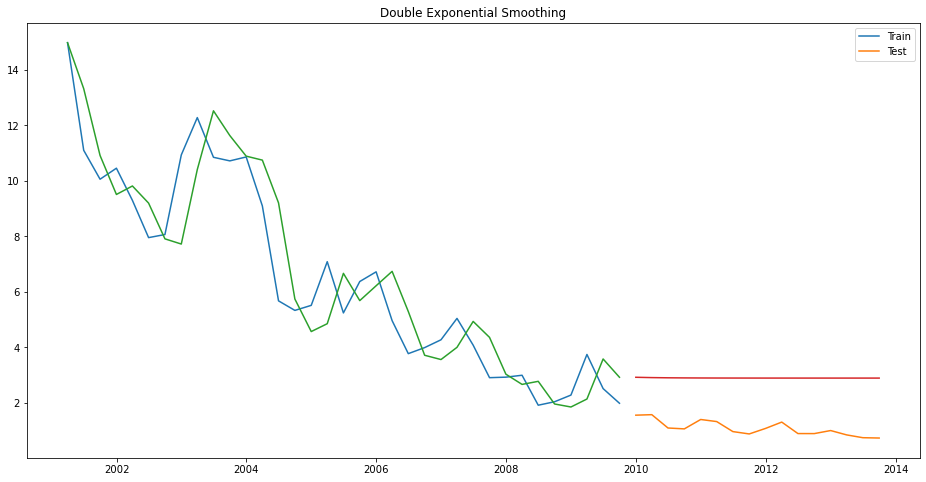

For alpha = 0.60, beta = 0.80 and phi =0.90, RMSE is 2.635 MAPE is 239.61


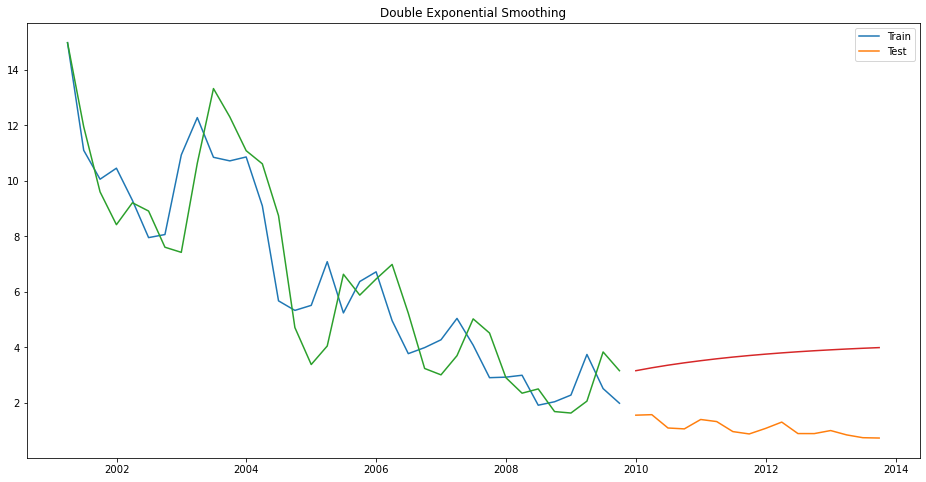

For alpha = 0.60, beta = 0.80 and phi =1.00, RMSE is 3.773 MAPE is 334.13


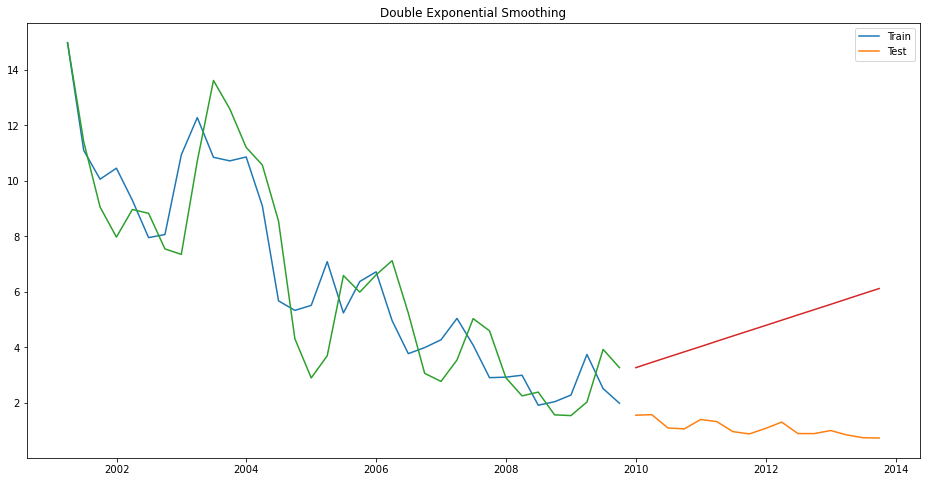

For alpha = 0.60, beta = 0.80 and phi =1.20, RMSE is 16.603 MAPE is 1201.87


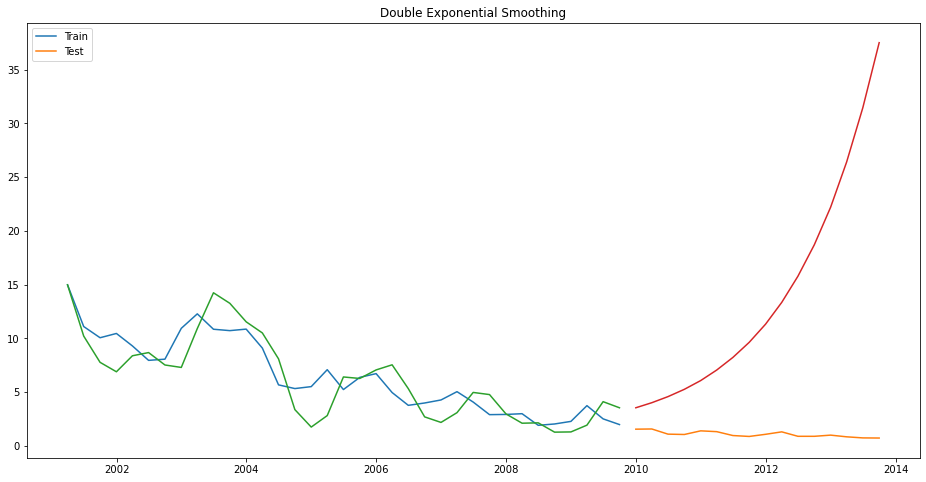

For alpha = 0.99, beta = 0.80 and phi =0.00, RMSE is 1.466 MAPE is 133.44


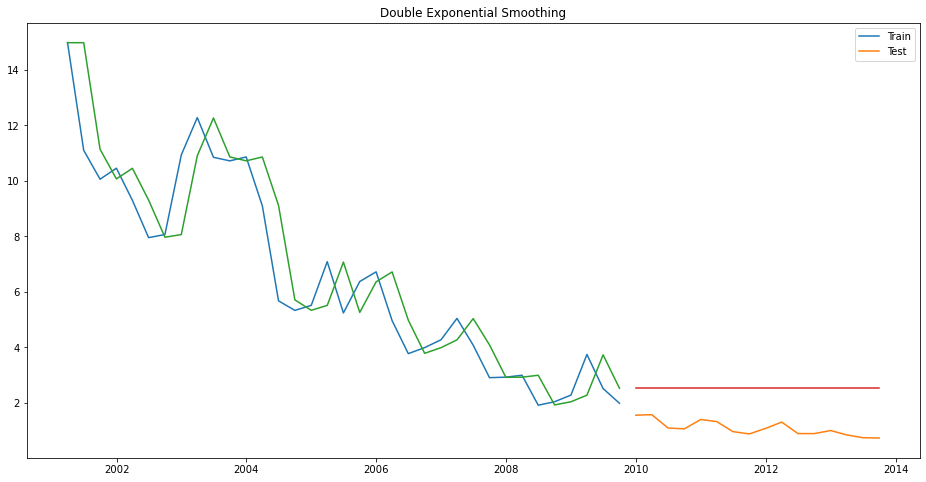

For alpha = 0.99, beta = 0.80 and phi =0.30, RMSE is 1.102 MAPE is  99.42


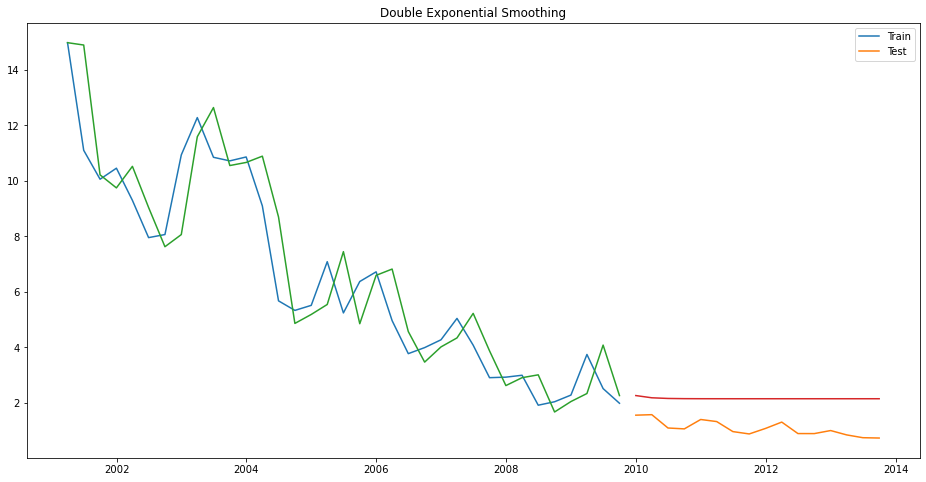

For alpha = 0.99, beta = 0.80 and phi =0.60, RMSE is 0.387 MAPE is  31.49


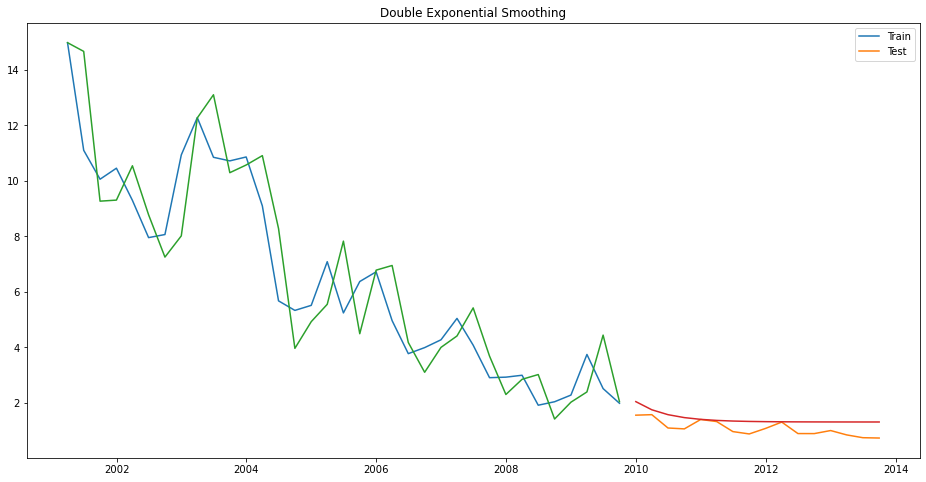

For alpha = 0.99, beta = 0.80 and phi =0.90, RMSE is 2.490 MAPE is 203.09


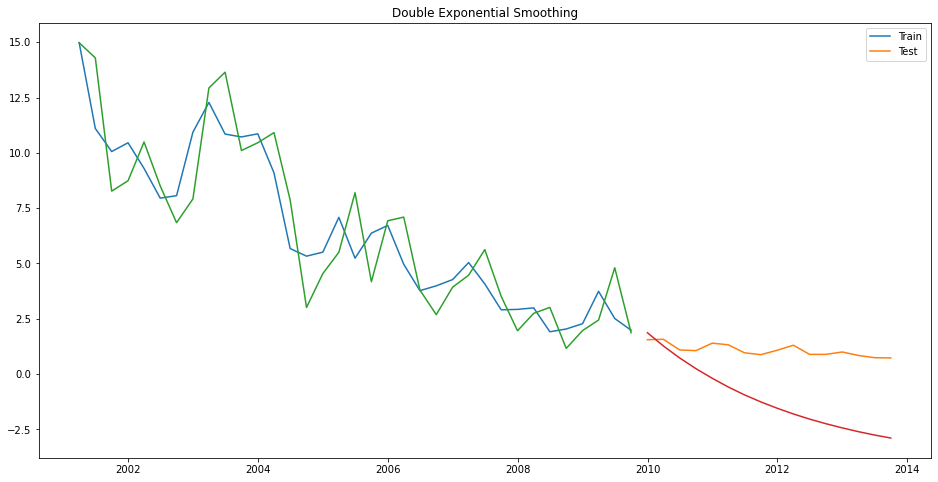

For alpha = 0.99, beta = 0.80 and phi =1.00, RMSE is 5.557 MAPE is 430.63


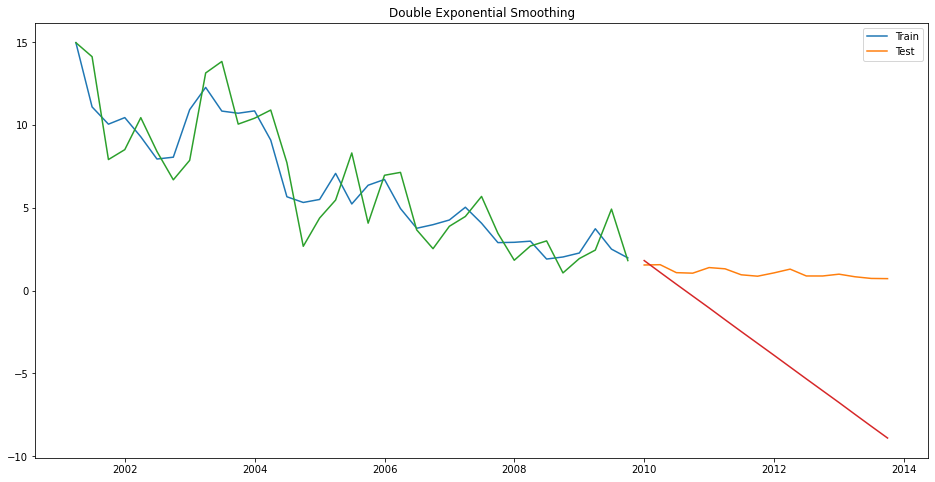

For alpha = 0.99, beta = 0.80 and phi =1.20, RMSE is 29.027 MAPE is 1915.23


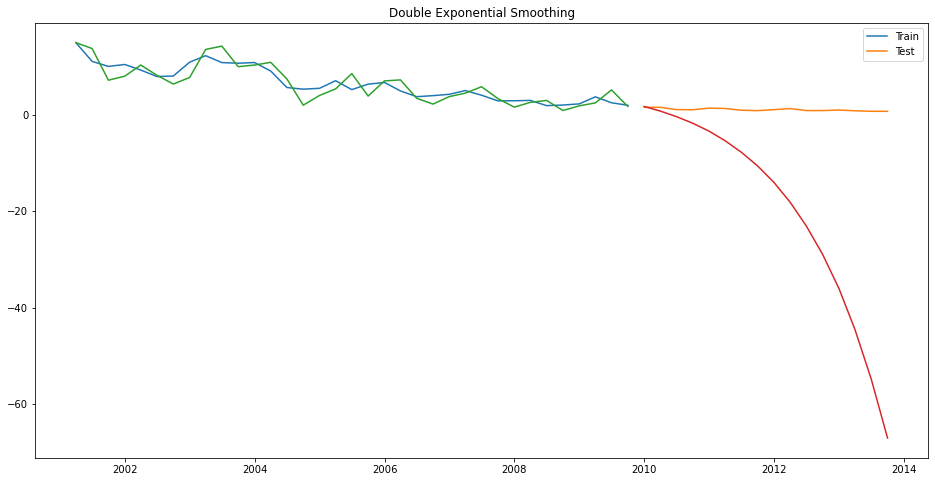

For alpha = 0.20, beta = 0.60 and phi =0.00, RMSE is 2.014 MAPE is 184.81


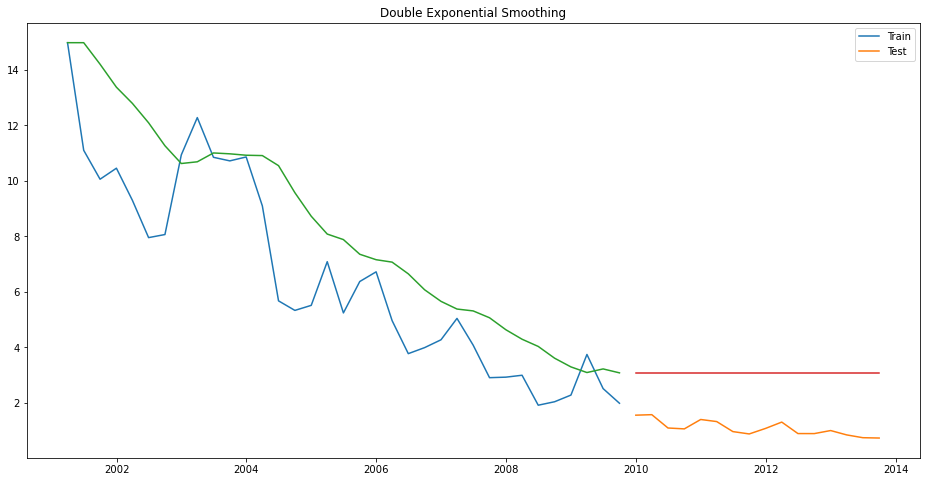

For alpha = 0.20, beta = 0.60 and phi =0.30, RMSE is 1.815 MAPE is 166.25


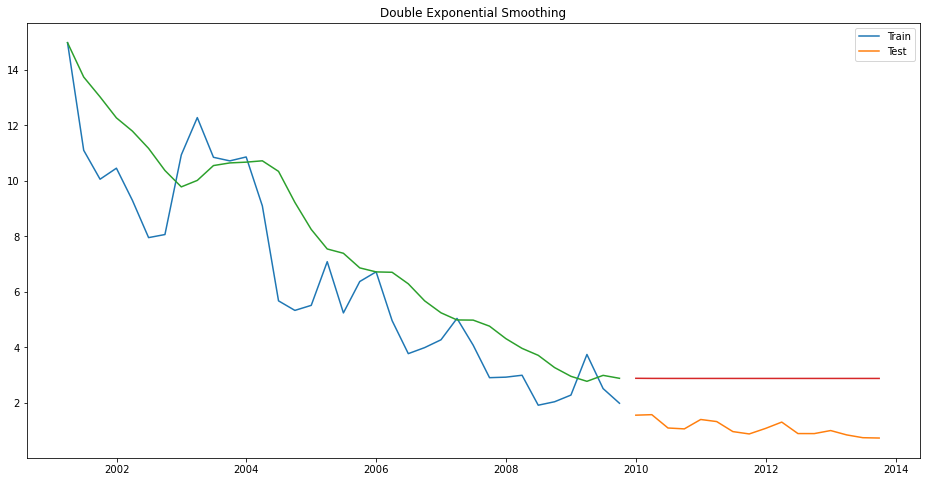

For alpha = 0.20, beta = 0.60 and phi =0.60, RMSE is 1.585 MAPE is 144.62


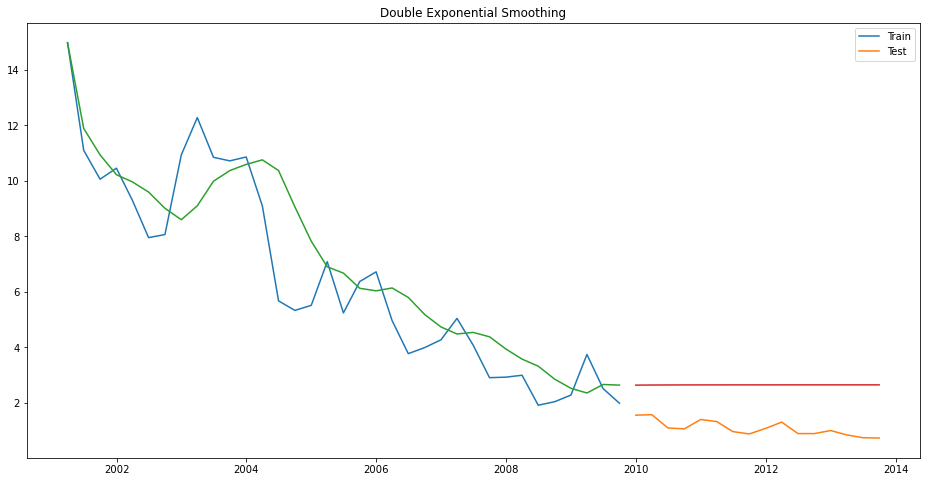

For alpha = 0.20, beta = 0.60 and phi =0.90, RMSE is 1.186 MAPE is 107.24


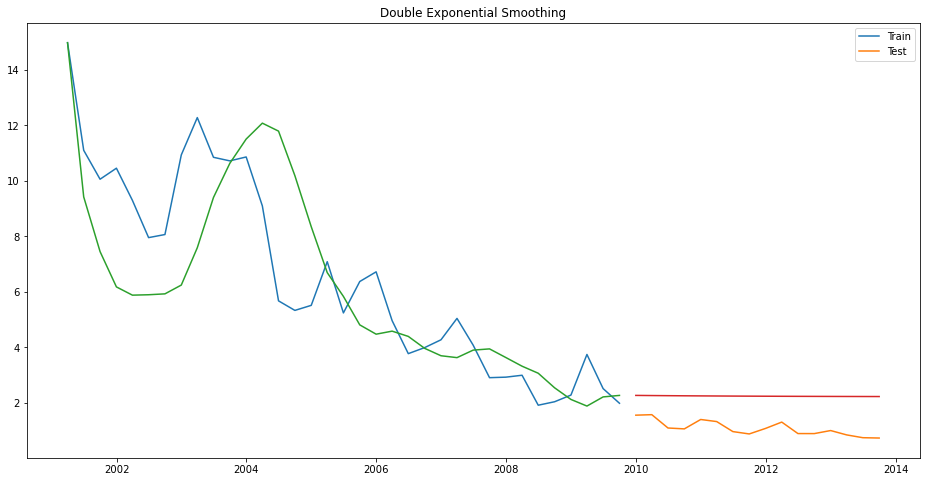

For alpha = 0.20, beta = 0.60 and phi =1.00, RMSE is 0.533 MAPE is  42.21


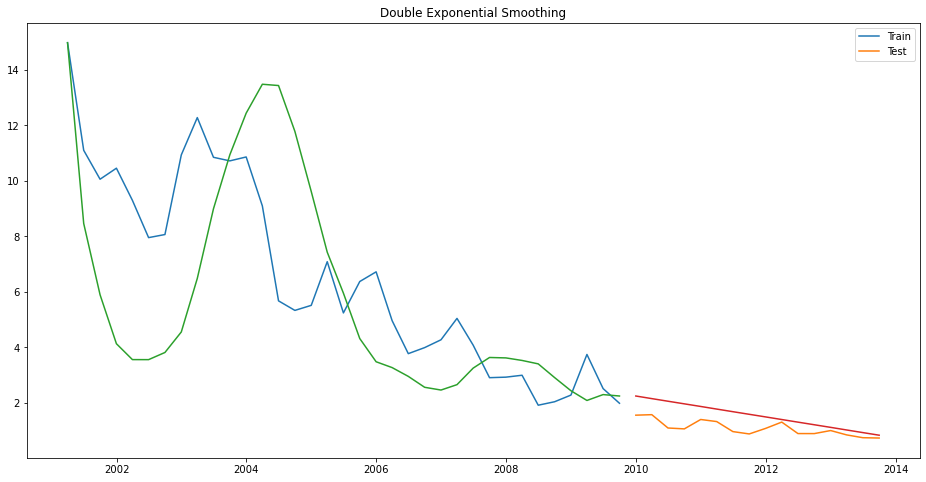

For alpha = 0.20, beta = 0.60 and phi =1.20, RMSE is 61.317 MAPE is 4492.04


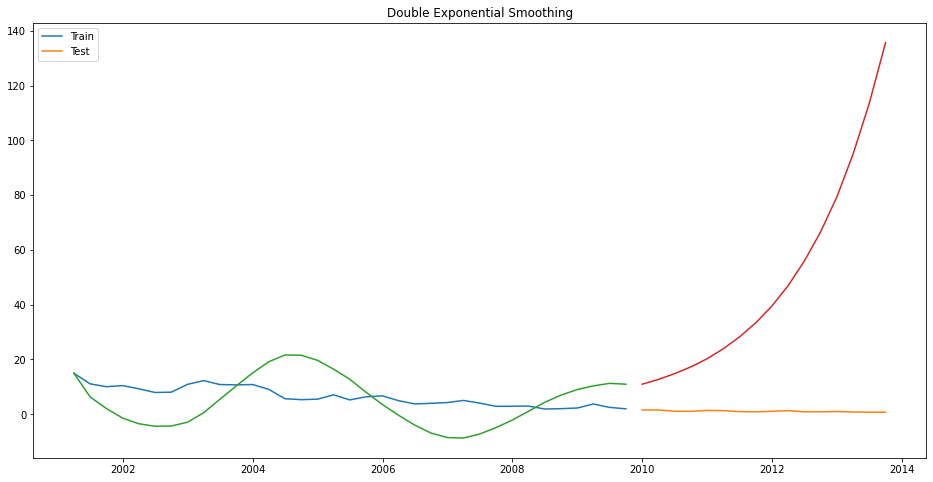

For alpha = 0.60, beta = 0.60 and phi =0.00, RMSE is 1.701 MAPE is 155.54


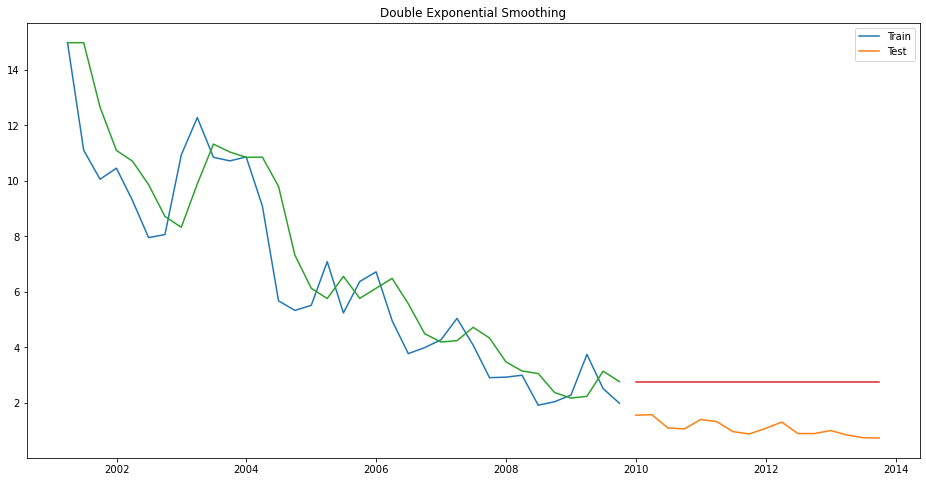

For alpha = 0.60, beta = 0.60 and phi =0.30, RMSE is 1.715 MAPE is 156.91


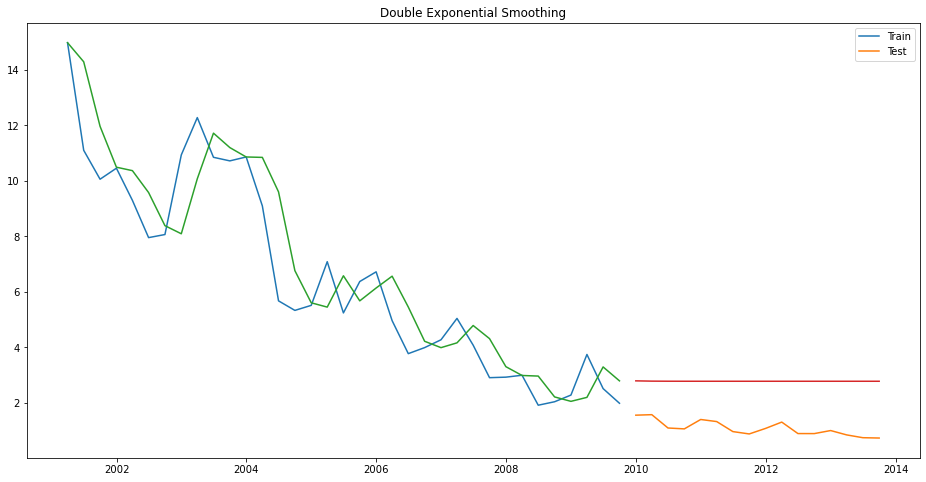

For alpha = 0.60, beta = 0.60 and phi =0.60, RMSE is 1.841 MAPE is 168.58


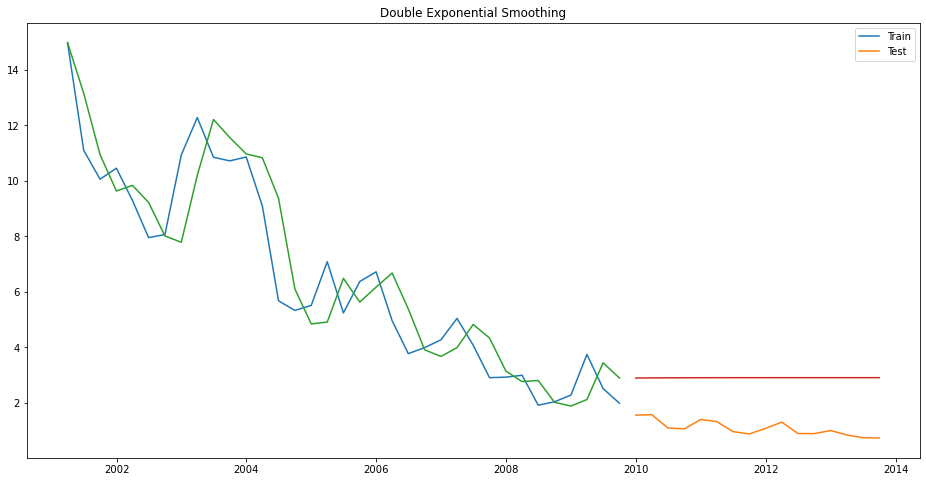

For alpha = 0.60, beta = 0.60 and phi =0.90, RMSE is 2.642 MAPE is 239.53


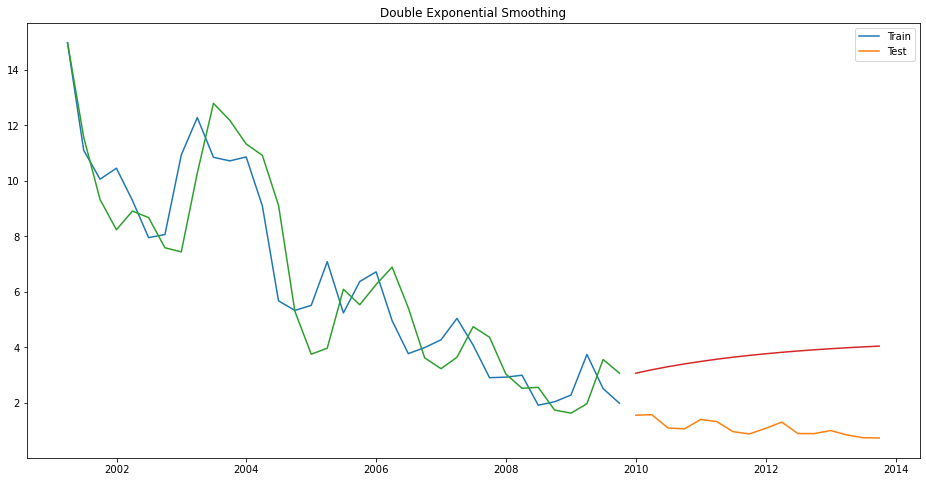

For alpha = 0.60, beta = 0.60 and phi =1.00, RMSE is 3.716 MAPE is 327.51


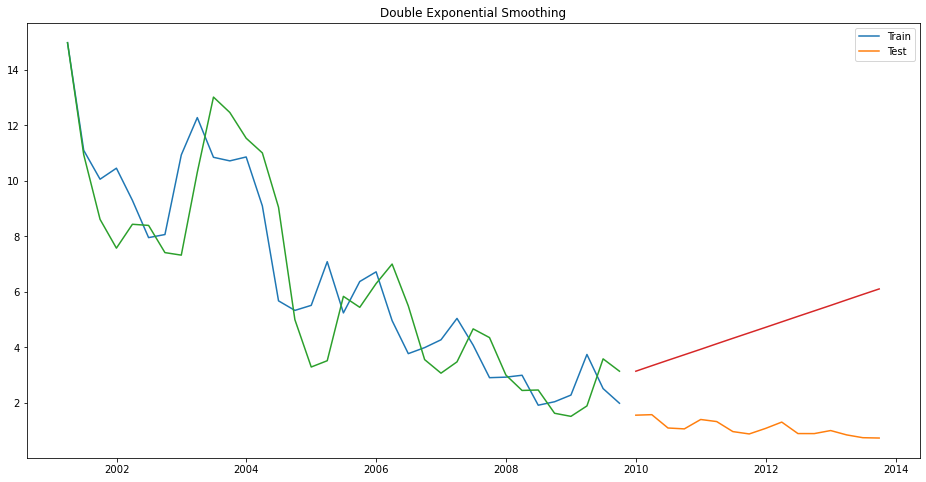

For alpha = 0.60, beta = 0.60 and phi =1.20, RMSE is 14.425 MAPE is 1045.40


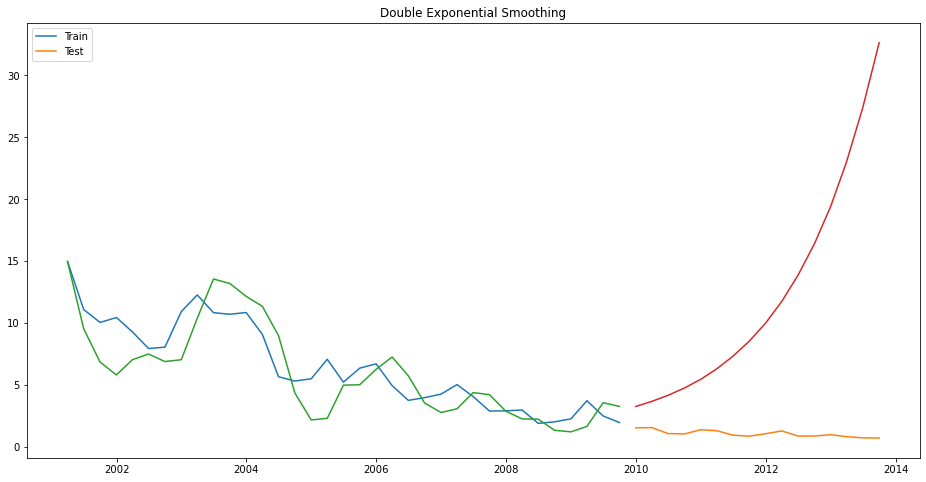

For alpha = 0.99, beta = 0.60 and phi =0.00, RMSE is 1.466 MAPE is 133.44


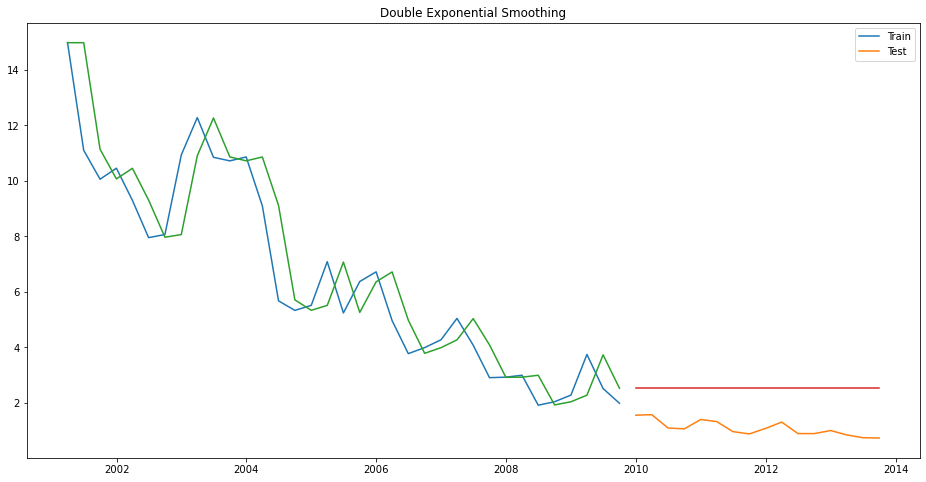

For alpha = 0.99, beta = 0.60 and phi =0.30, RMSE is 1.215 MAPE is 109.99


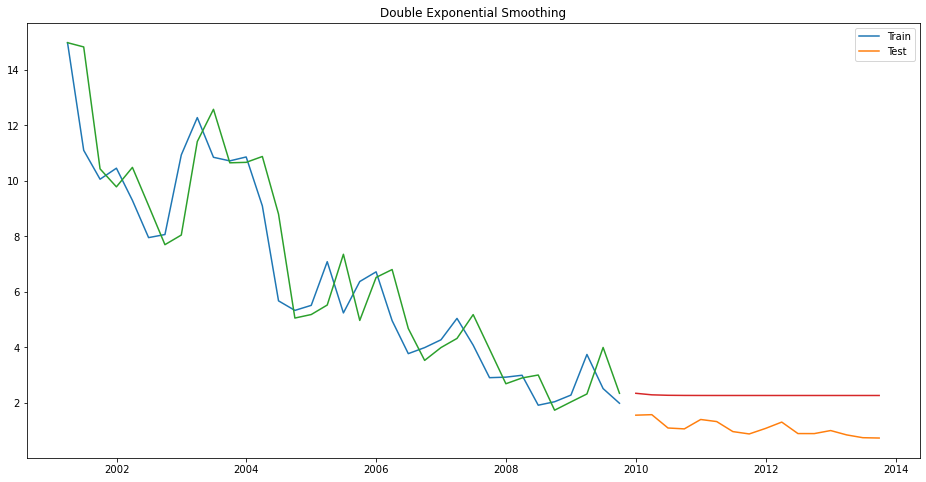

For alpha = 0.99, beta = 0.60 and phi =0.60, RMSE is 0.788 MAPE is  70.69


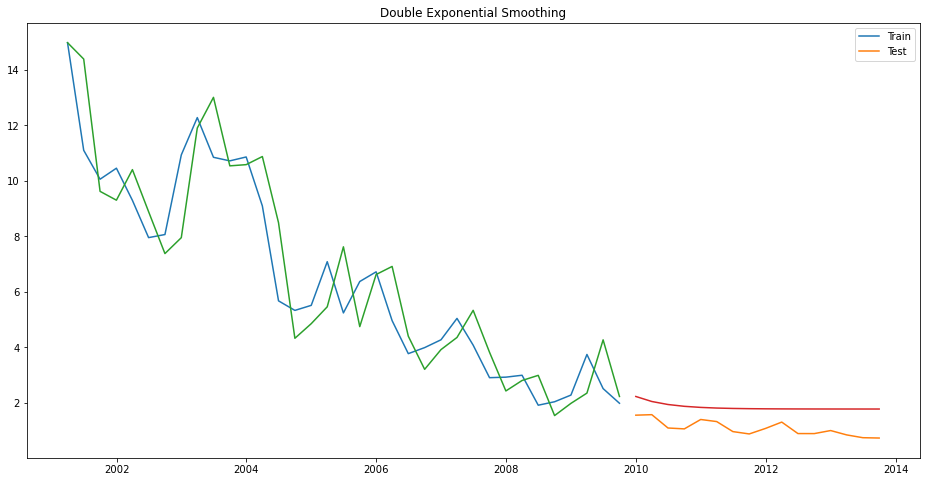

For alpha = 0.99, beta = 0.60 and phi =0.90, RMSE is 0.743 MAPE is  62.11


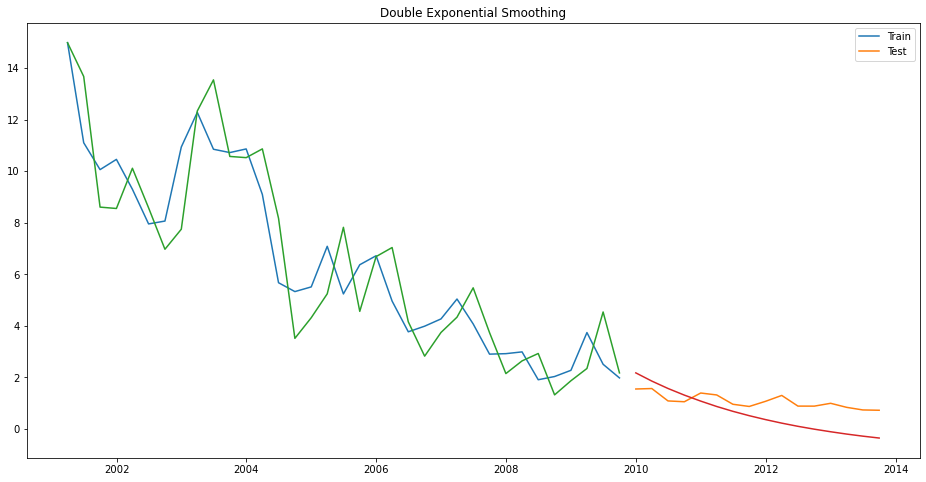

For alpha = 0.99, beta = 0.60 and phi =1.00, RMSE is 2.150 MAPE is 161.89


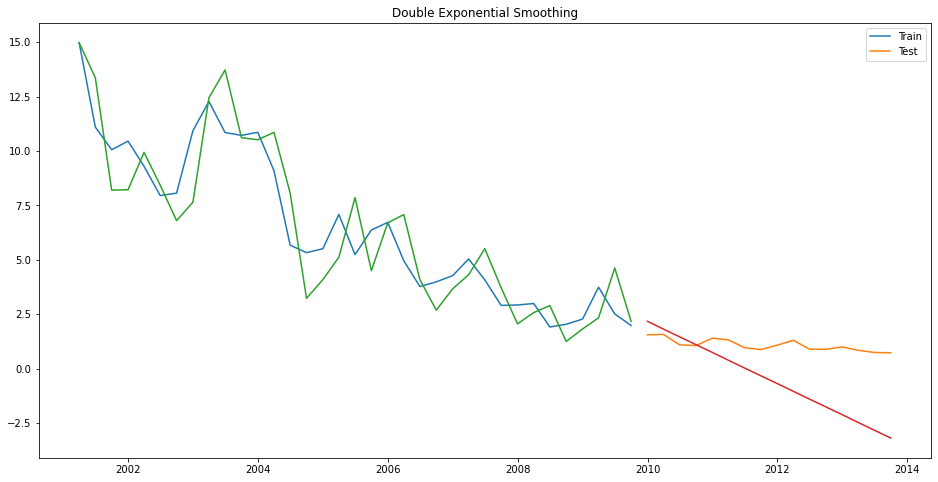

For alpha = 0.99, beta = 0.60 and phi =1.20, RMSE is 12.210 MAPE is 783.43


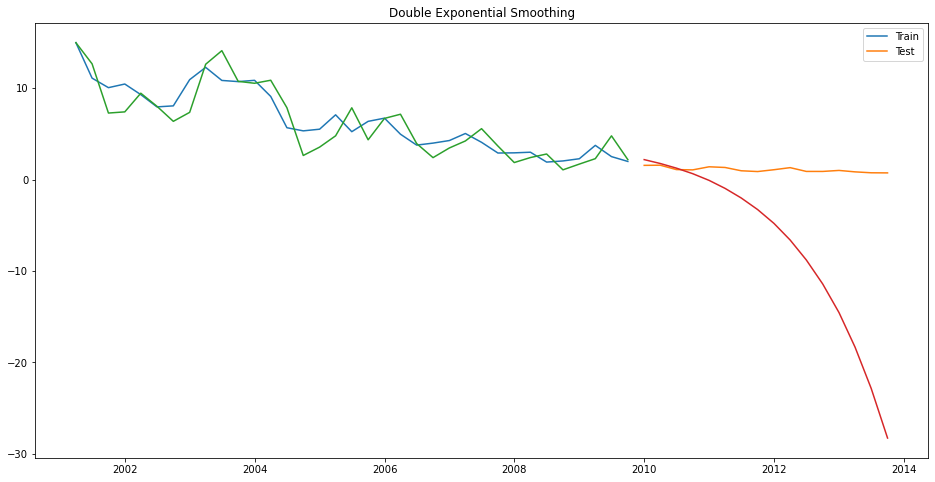

For alpha = 0.20, beta = 0.20 and phi =0.00, RMSE is 2.014 MAPE is 184.81


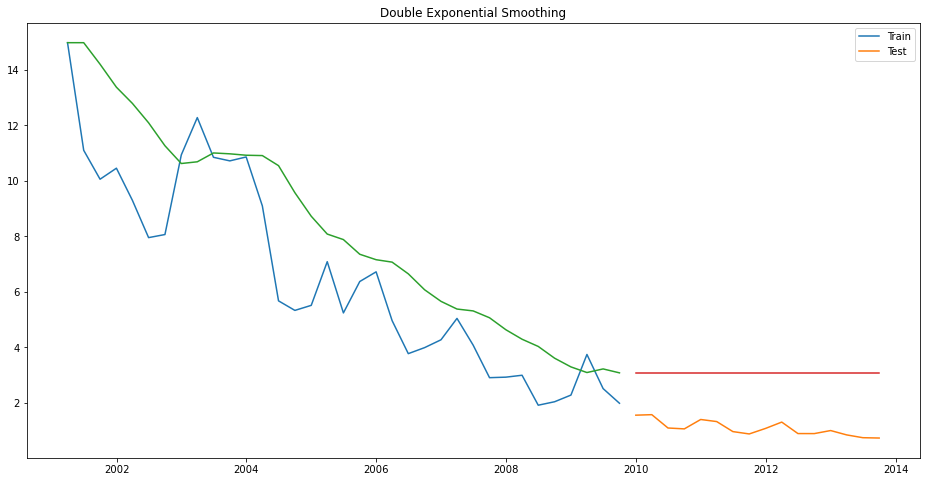

For alpha = 0.20, beta = 0.20 and phi =0.30, RMSE is 1.930 MAPE is 176.93


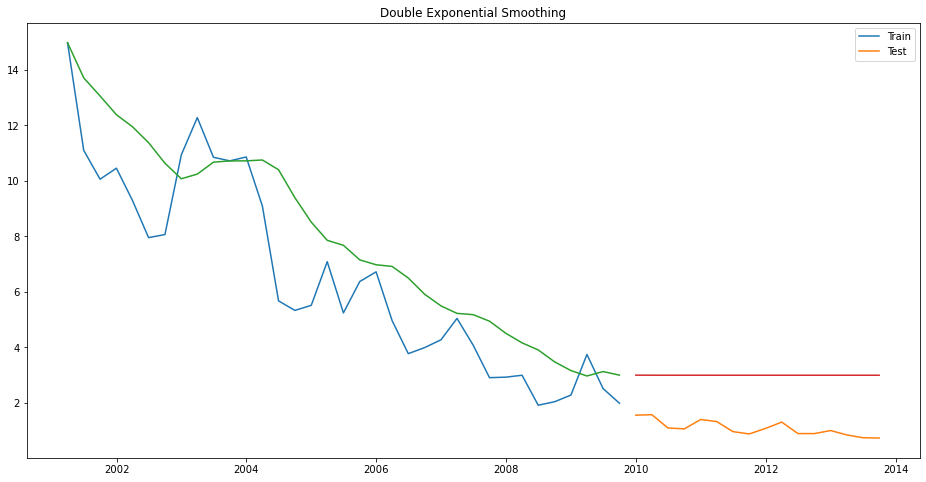

For alpha = 0.20, beta = 0.20 and phi =0.60, RMSE is 1.733 MAPE is 158.64


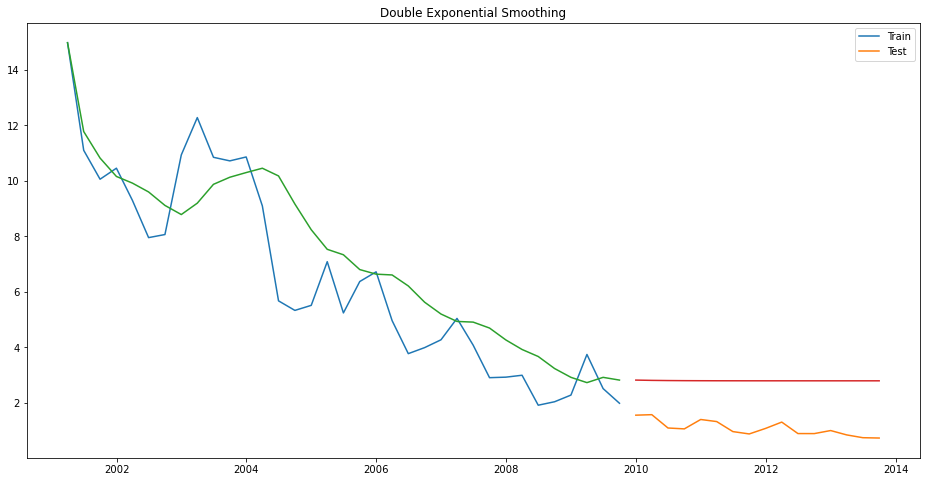

For alpha = 0.20, beta = 0.20 and phi =0.90, RMSE is 0.734 MAPE is  66.36


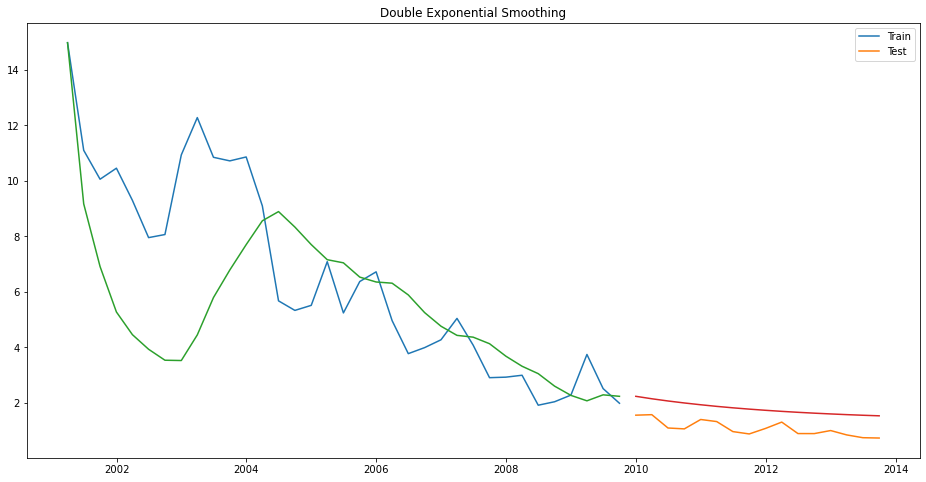

For alpha = 0.20, beta = 0.20 and phi =1.00, RMSE is 1.403 MAPE is 105.06


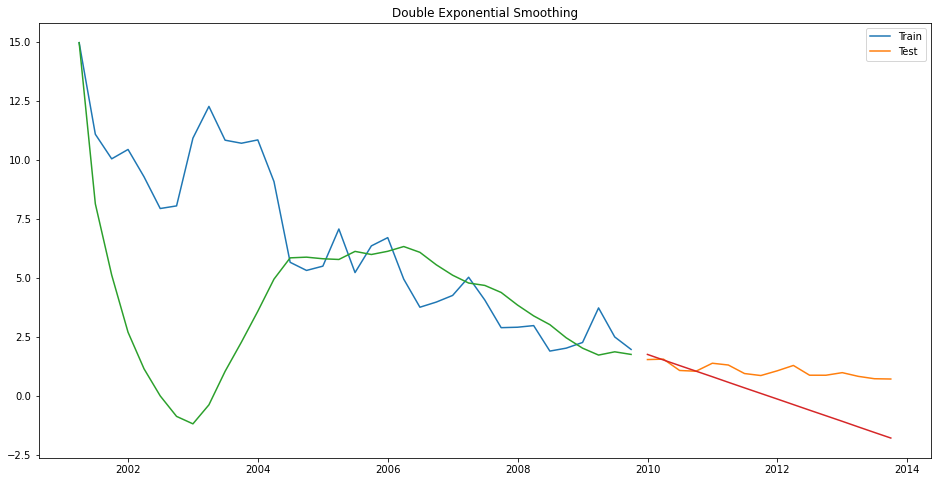

For alpha = 0.20, beta = 0.20 and phi =1.20, RMSE is 60.678 MAPE is 4666.01


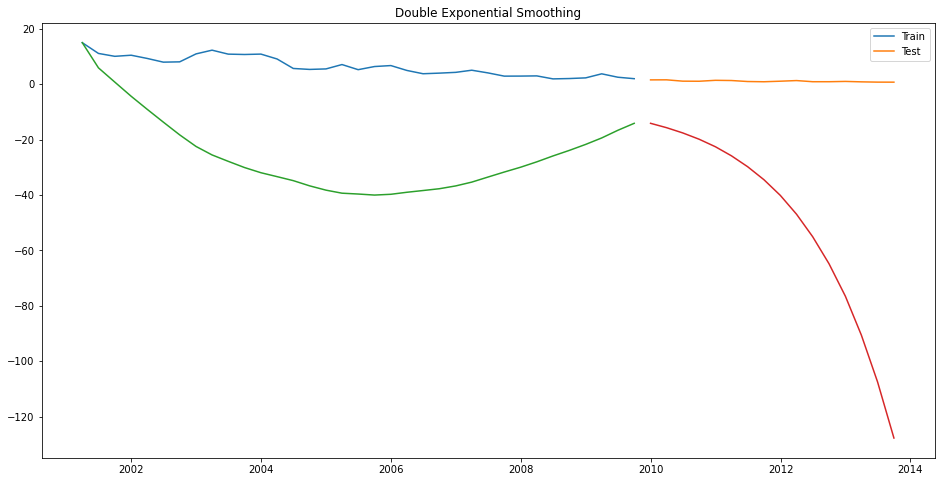

For alpha = 0.60, beta = 0.20 and phi =0.00, RMSE is 1.701 MAPE is 155.54


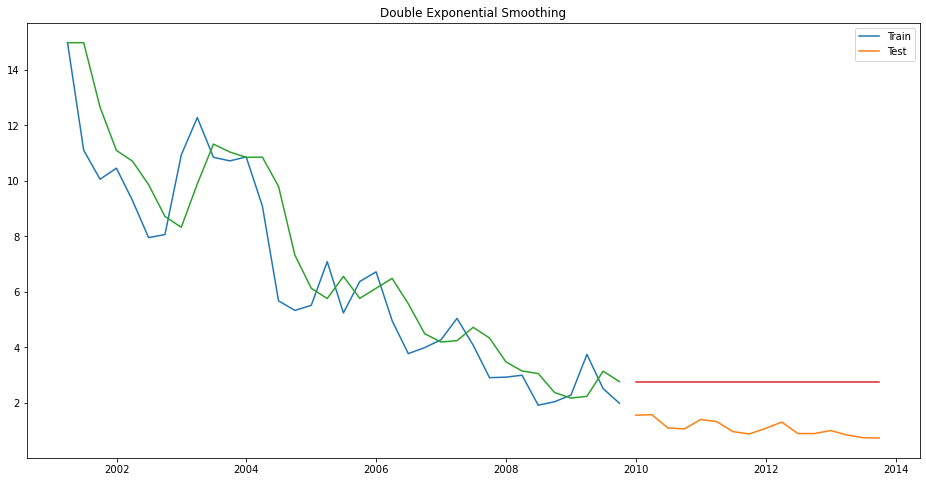

For alpha = 0.60, beta = 0.20 and phi =0.30, RMSE is 1.709 MAPE is 156.25


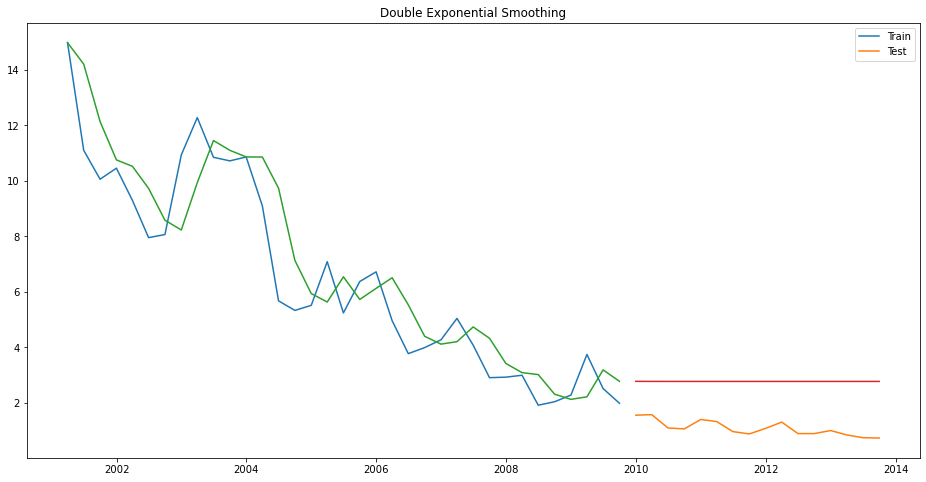

For alpha = 0.60, beta = 0.20 and phi =0.60, RMSE is 1.746 MAPE is 159.69


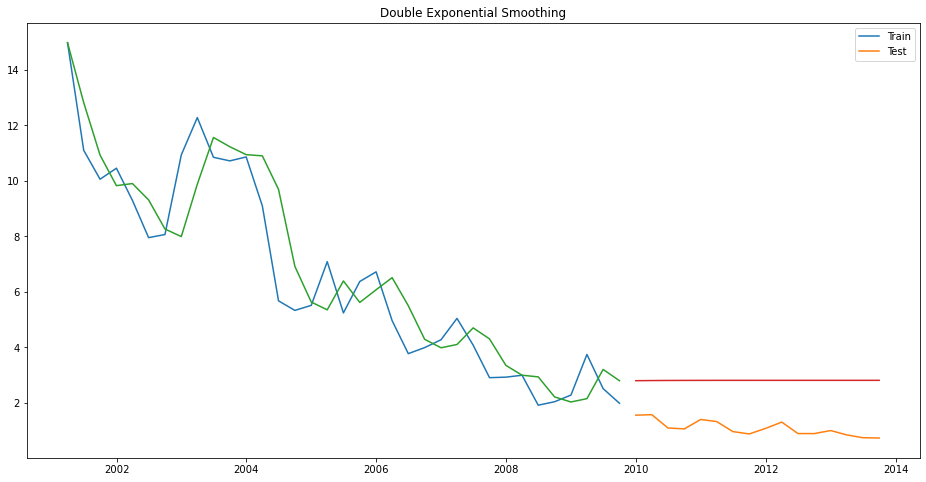

For alpha = 0.60, beta = 0.20 and phi =0.90, RMSE is 1.643 MAPE is 150.22


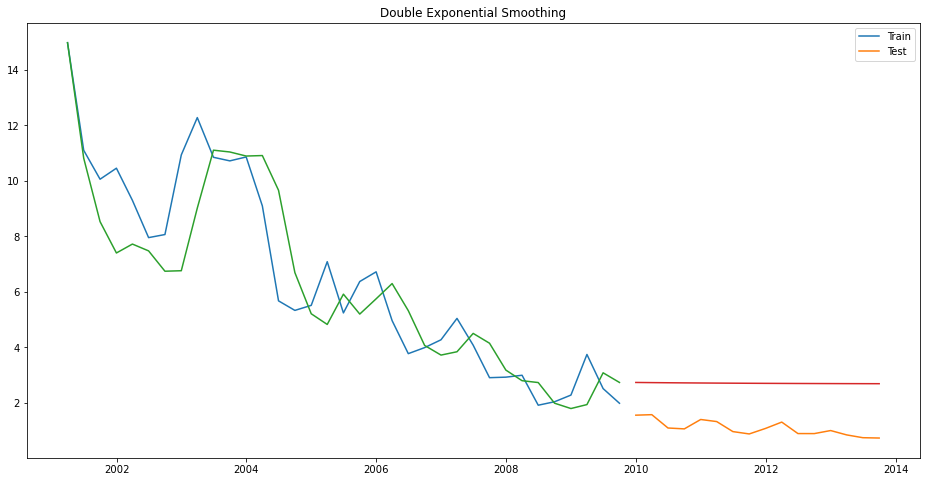

For alpha = 0.60, beta = 0.20 and phi =1.00, RMSE is 1.021 MAPE is  92.81


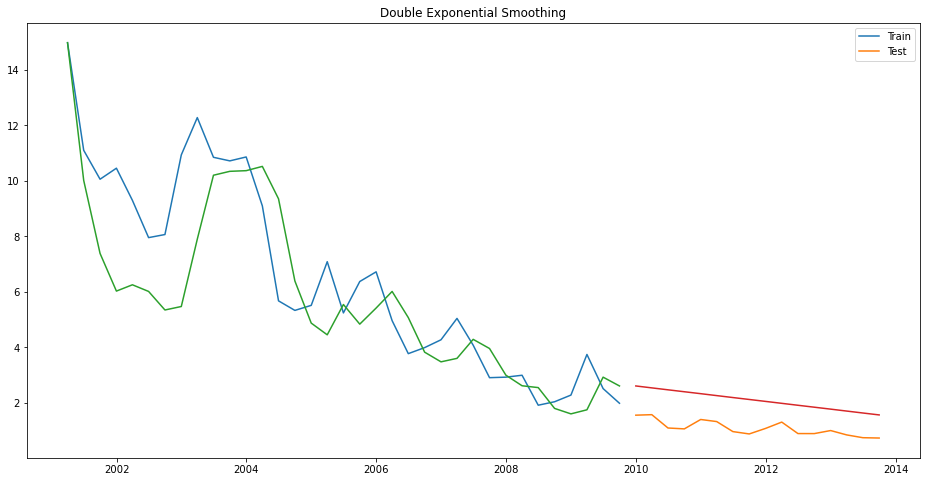

For alpha = 0.60, beta = 0.20 and phi =1.20, RMSE is 92.370 MAPE is 6273.51


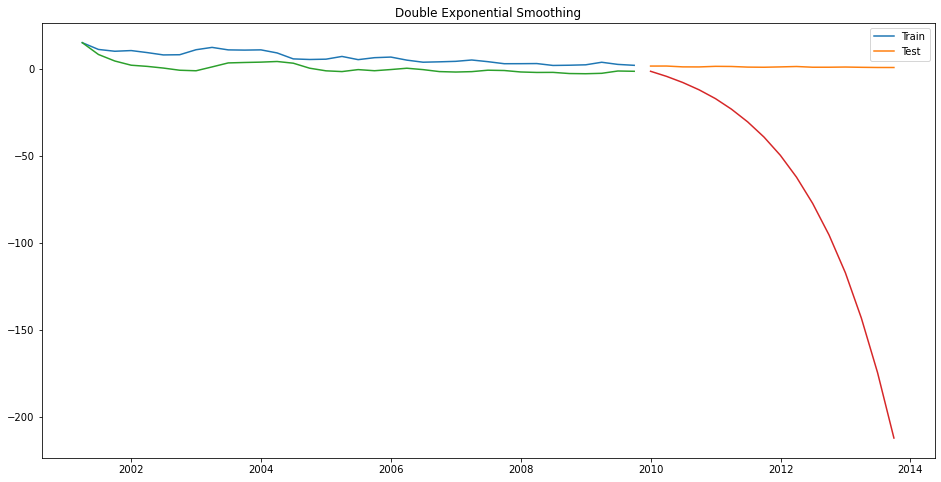

For alpha = 0.99, beta = 0.20 and phi =0.00, RMSE is 1.466 MAPE is 133.44


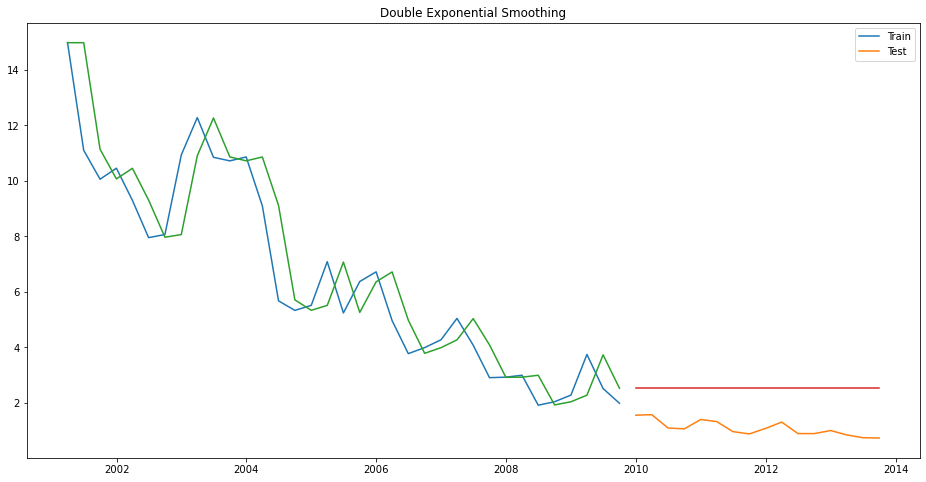

For alpha = 0.99, beta = 0.20 and phi =0.30, RMSE is 1.397 MAPE is 127.02


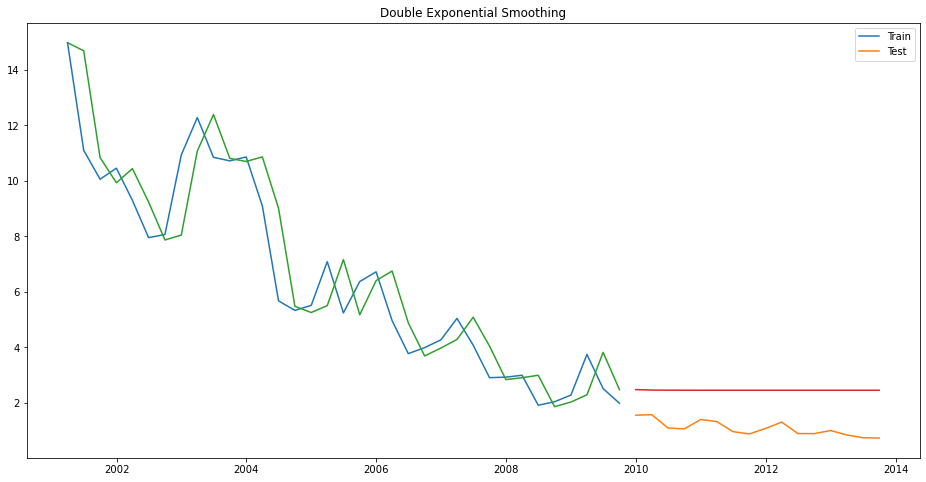

For alpha = 0.99, beta = 0.20 and phi =0.60, RMSE is 1.331 MAPE is 121.02


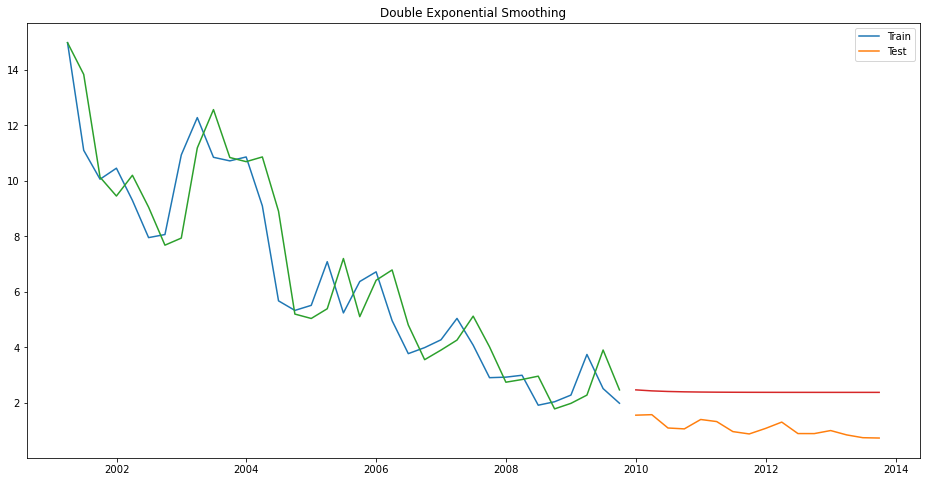

For alpha = 0.99, beta = 0.20 and phi =0.90, RMSE is 1.030 MAPE is  94.12


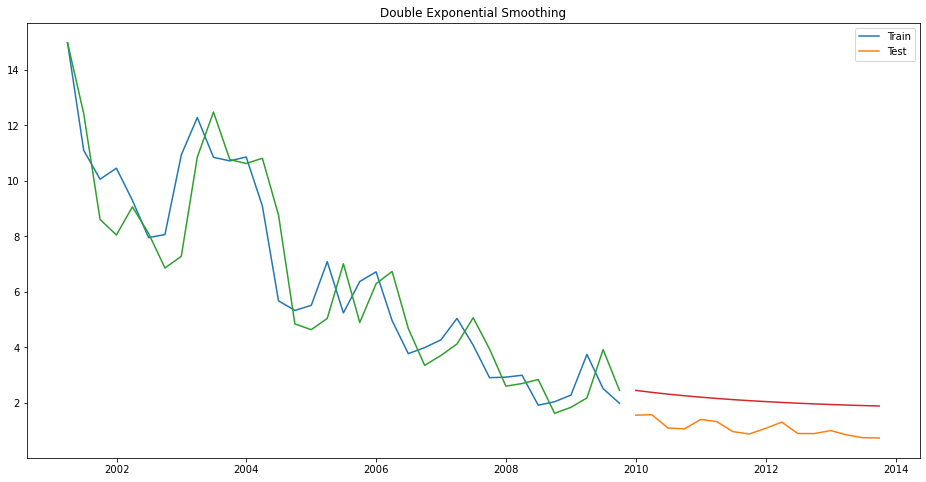

For alpha = 0.99, beta = 0.20 and phi =1.00, RMSE is 0.528 MAPE is  41.46


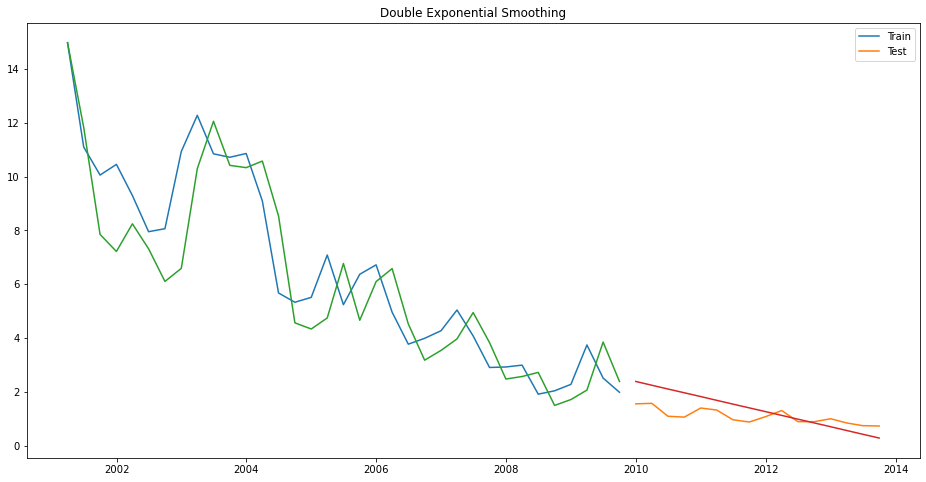

For alpha = 0.99, beta = 0.20 and phi =1.20, RMSE is 93.264 MAPE is 6269.21


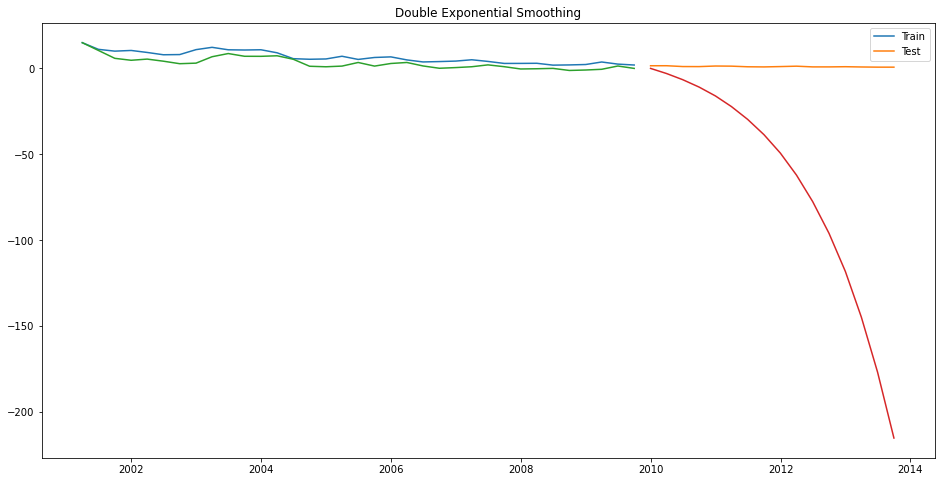

For alpha = 0.20, beta = 0.05 and phi =0.00, RMSE is 2.014 MAPE is 184.81


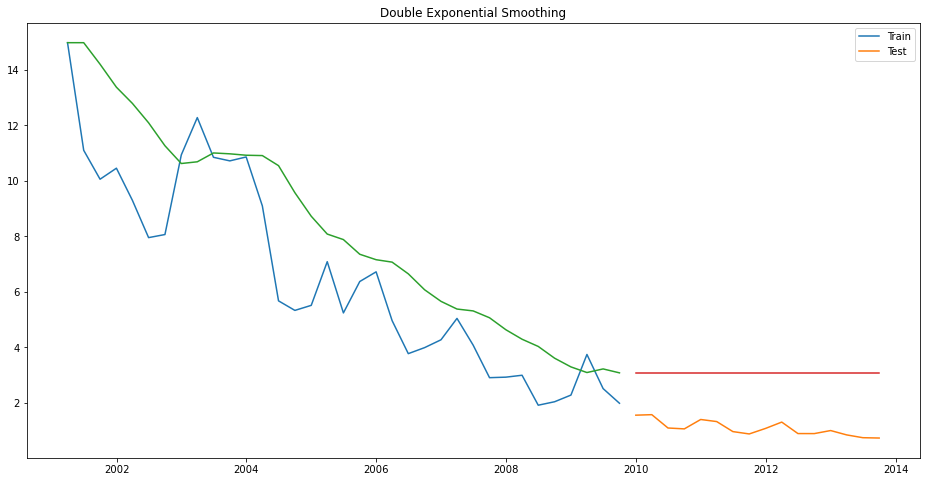

For alpha = 0.20, beta = 0.05 and phi =0.30, RMSE is 1.990 MAPE is 182.58


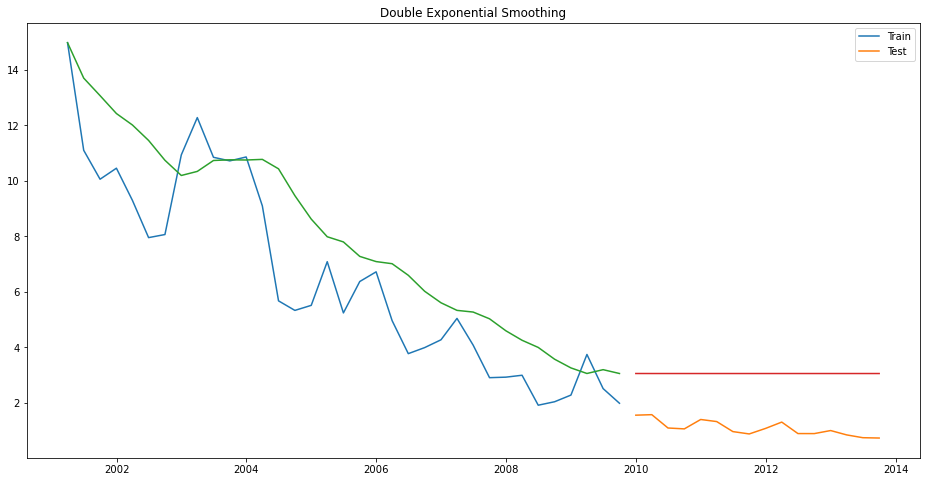

For alpha = 0.20, beta = 0.05 and phi =0.60, RMSE is 1.918 MAPE is 175.85


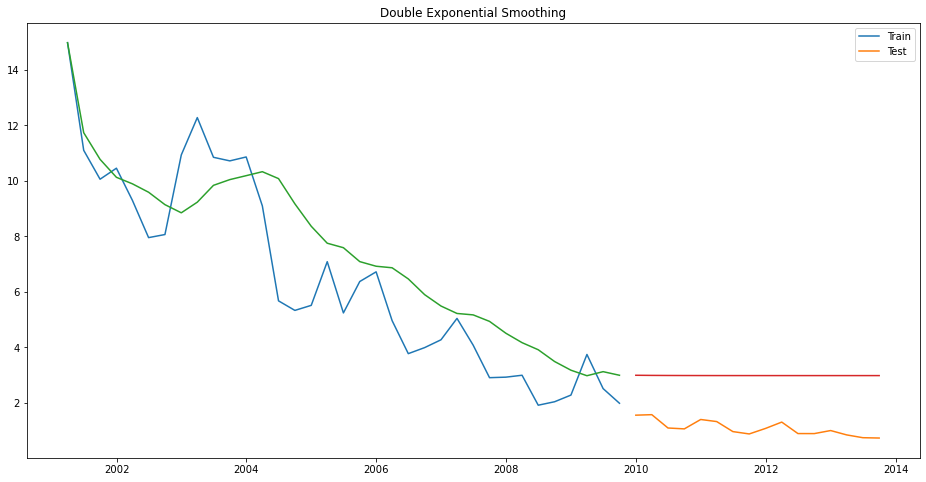

For alpha = 0.20, beta = 0.05 and phi =0.90, RMSE is 1.241 MAPE is 113.71


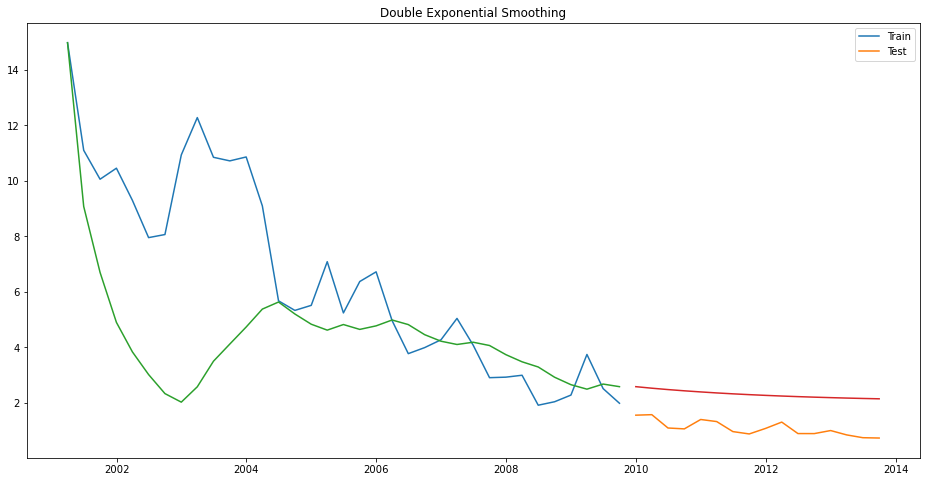

For alpha = 0.20, beta = 0.05 and phi =1.00, RMSE is 10.335 MAPE is 894.84


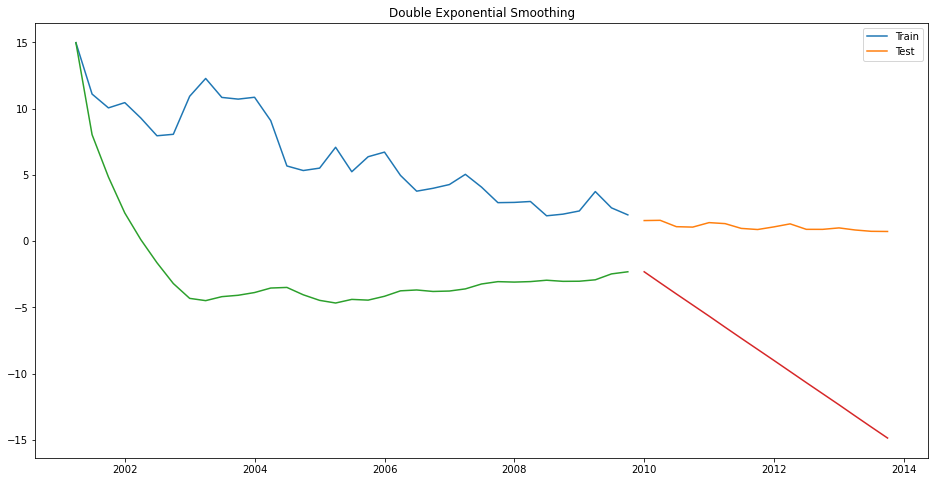

For alpha = 0.20, beta = 0.05 and phi =1.20, RMSE is 33380.927 MAPE is 2340894.03


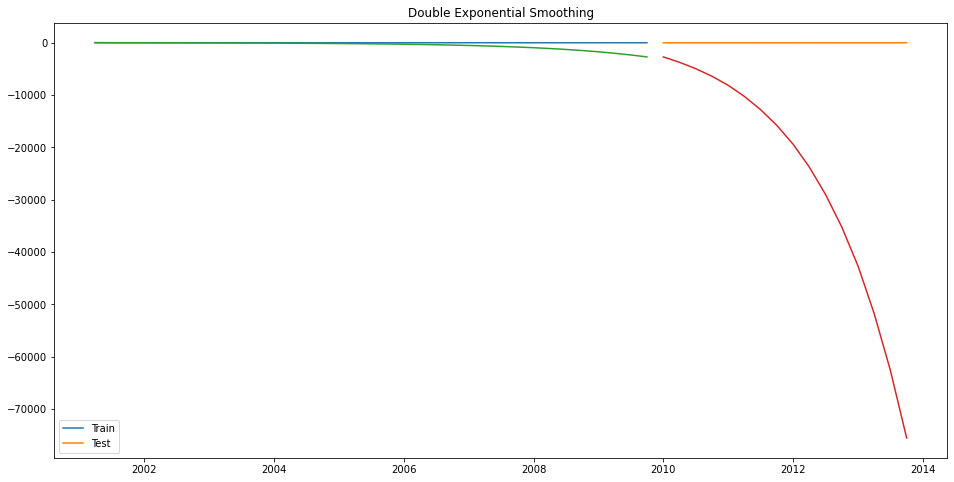

For alpha = 0.60, beta = 0.05 and phi =0.00, RMSE is 1.701 MAPE is 155.54


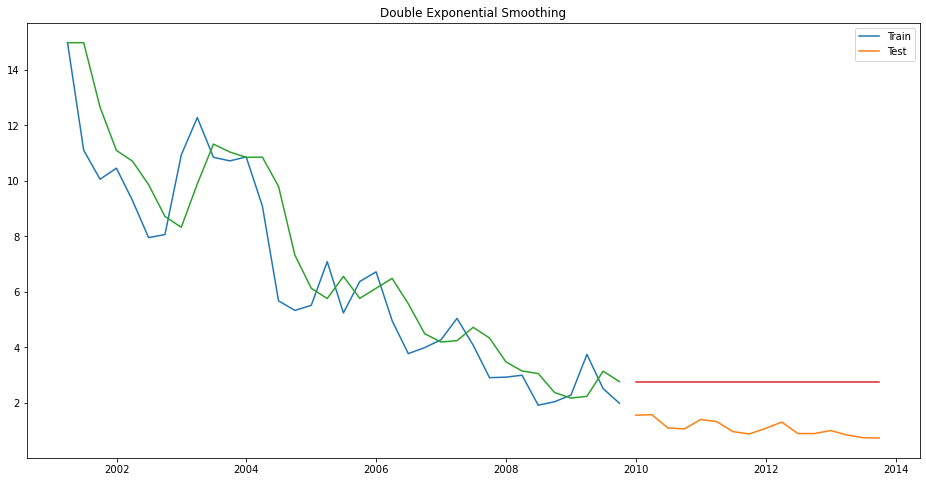

For alpha = 0.60, beta = 0.05 and phi =0.30, RMSE is 1.703 MAPE is 155.72


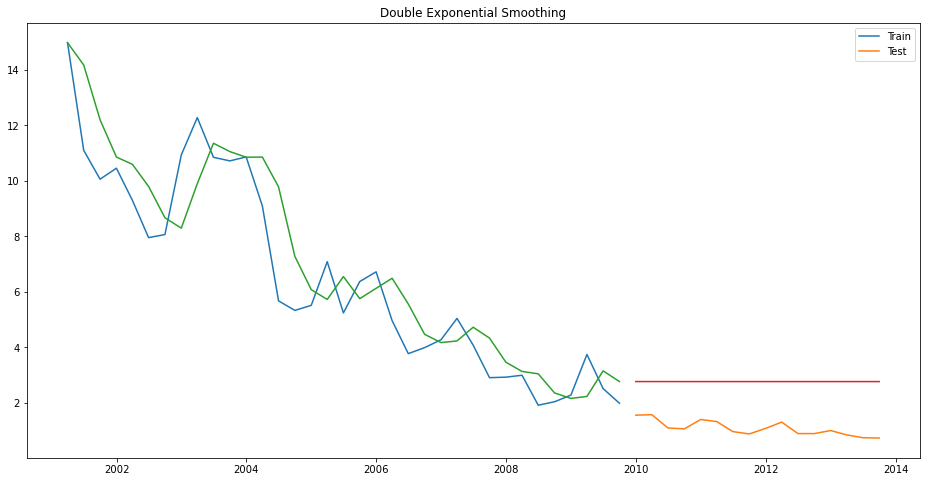

For alpha = 0.60, beta = 0.05 and phi =0.60, RMSE is 1.707 MAPE is 156.08


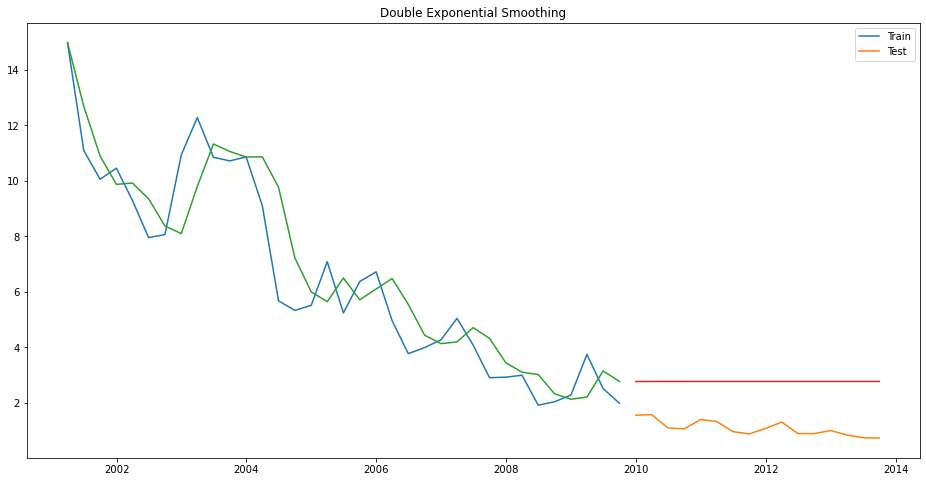

For alpha = 0.60, beta = 0.05 and phi =0.90, RMSE is 1.328 MAPE is 121.79


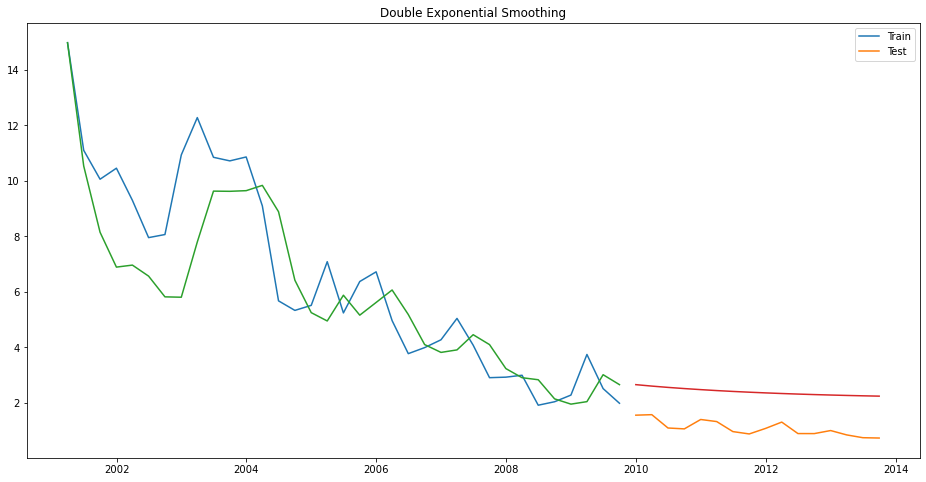

For alpha = 0.60, beta = 0.05 and phi =1.00, RMSE is 7.573 MAPE is 601.86


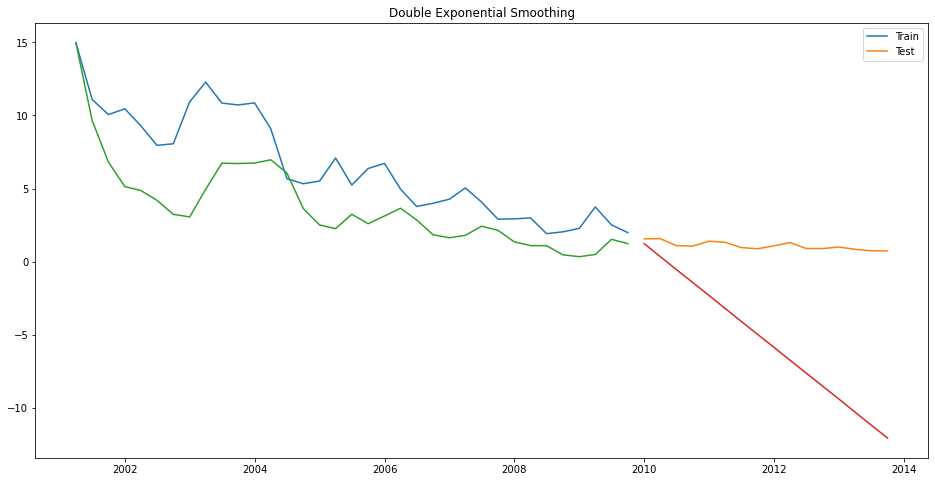

For alpha = 0.60, beta = 0.05 and phi =1.20, RMSE is 19079.632 MAPE is 1304558.36


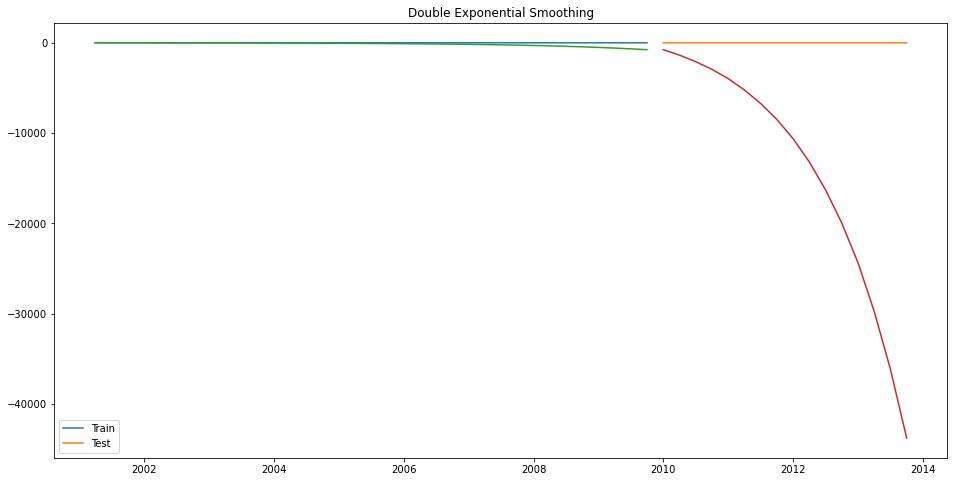

For alpha = 0.99, beta = 0.05 and phi =0.00, RMSE is 1.466 MAPE is 133.44


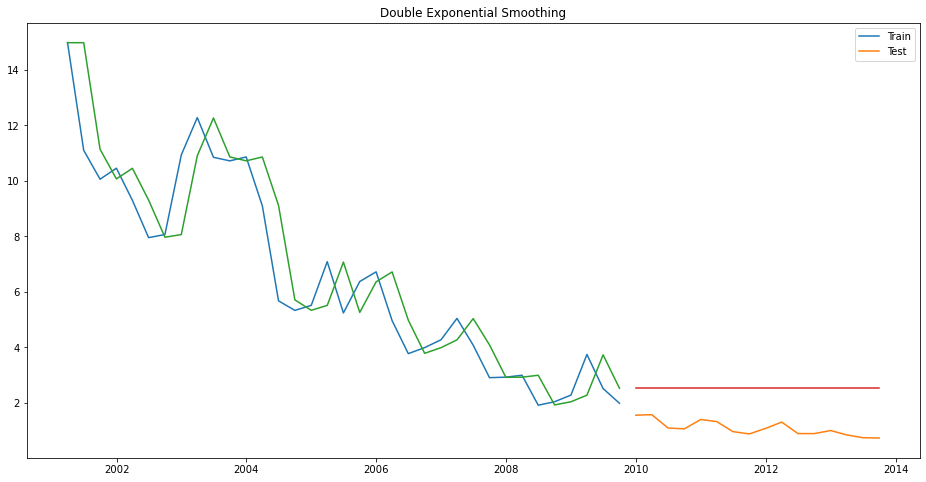

For alpha = 0.99, beta = 0.05 and phi =0.30, RMSE is 1.450 MAPE is 131.97


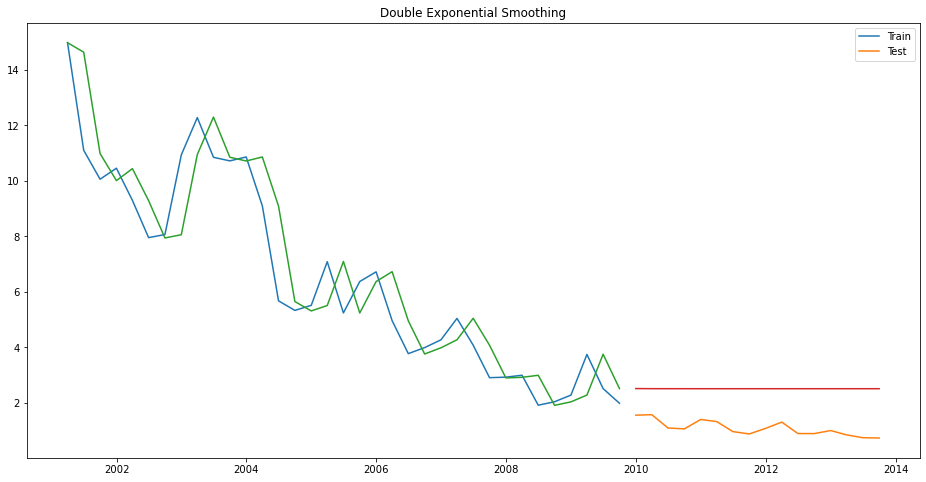

For alpha = 0.99, beta = 0.05 and phi =0.60, RMSE is 1.438 MAPE is 130.87


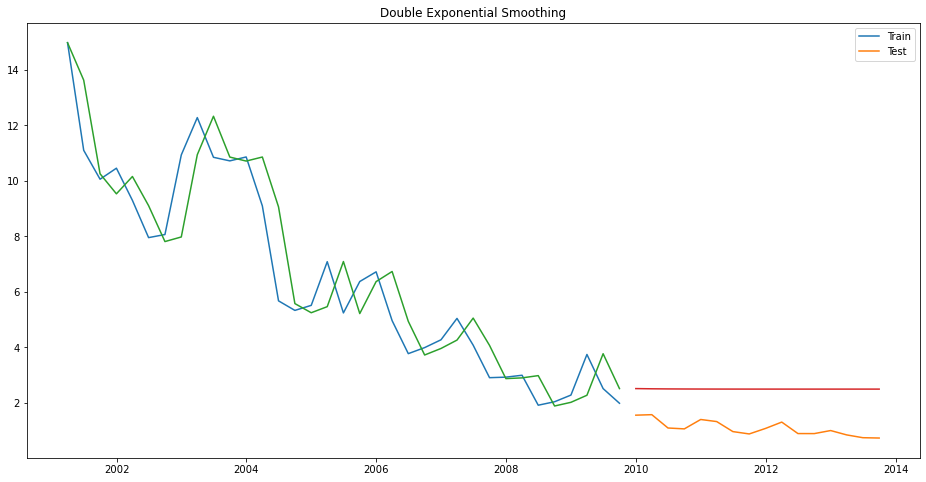

For alpha = 0.99, beta = 0.05 and phi =0.90, RMSE is 1.077 MAPE is  98.49


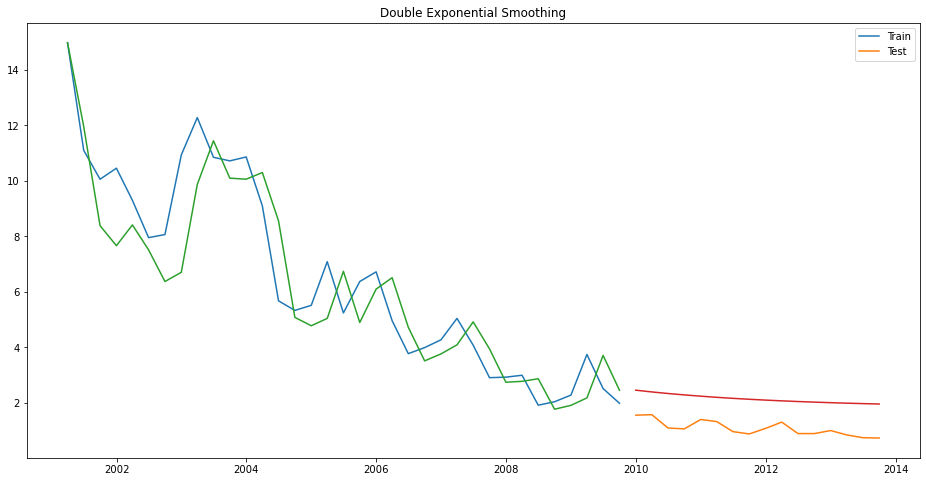

For alpha = 0.99, beta = 0.05 and phi =1.00, RMSE is 7.439 MAPE is 582.33


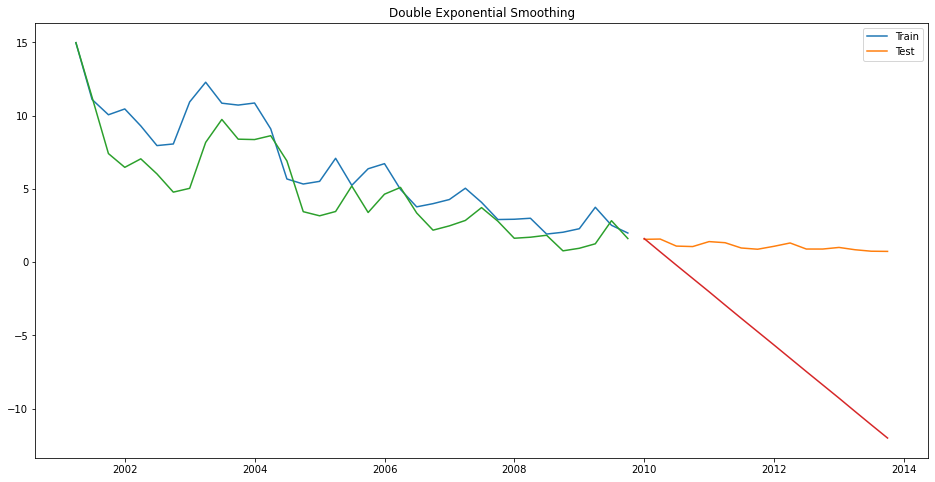

For alpha = 0.99, beta = 0.05 and phi =1.20, RMSE is 16138.669 MAPE is 1093980.66


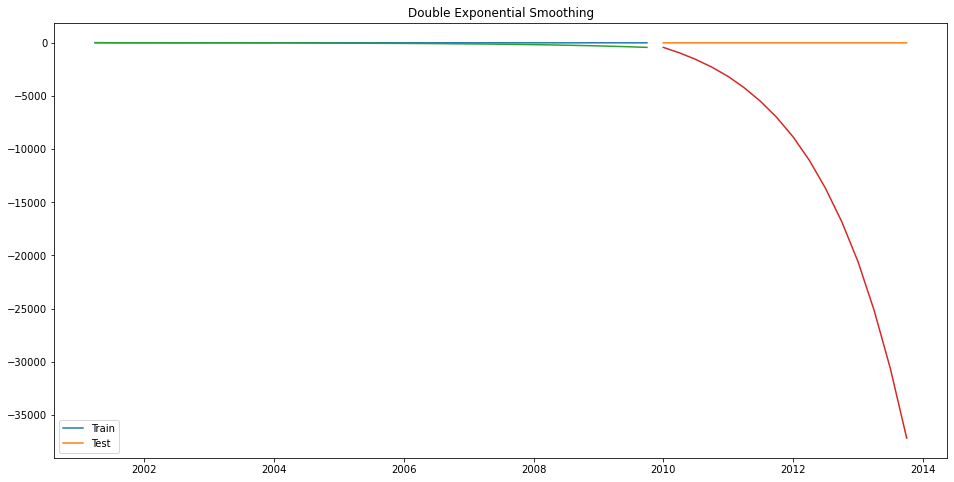

In [56]:
alpha_list = [0.2, 0.6, 0.99]
beta_list = [0.8, 0.6, 0.2, 0.05]
phi_list = [0, 0.3, 0.6, 0.9, 1, 1.2]

Train= np.asarray(train['Consumption'])
Test= np.asarray(test['Consumption'])

DES_Train = np.zeros(len(Train))
DES_Test = np.zeros(len(Test))
L = np.zeros(len(Train))
LT = np.zeros(len(Test))
T = np.zeros(len(Train))
TT = np.zeros(len(Test))

#DES_Train[0] = 0
DES_Train[0] = Train[0]
L[0] = Train[0]
T[0] = Train[1] - Train[0]

for beta_value in beta_list:

    for alpha_value in alpha_list:
        
        for phi_value in phi_list:

            alpha_str =  "DES" + str(alpha_value)
            beta_str =  "DES" + str(beta_value)
            for i in range(len(Train)-1):
                L[i+1] = alpha_value*Train[i] + (1-alpha_value)*(L[i]+phi_value*T[i])
                T[i+1] = beta_value*(L[i+1]-L[i]) + (1-beta_value)*phi_value*T[i]
                DES_Train[i+1] = L[i+1]+phi_value*T[i+1]

            DES_Test[0] = DES_Train[34]
            LT[0] = L[34]
            TT[0] = T[34]
            for ii in range(len(Test)-1):
                LT[ii+1] = alpha_value*DES_Test[ii]+(1-alpha_value)*(LT[ii]+phi_value*TT[ii])            
                TT[ii+1] = beta_value*(LT[ii+1]-LT[ii])+(1 - beta_value)*phi_value*TT[ii]
                DES_Test[ii+1] = LT[ii+1]+phi_value*TT[ii+1]


            rmse =  np.sqrt(mean_squared_error(test['Consumption'], DES_Test))
            mape =  MAPE(test['Consumption'], DES_Test)
            ###
            print("For alpha = %1.2f, beta = %1.2f and phi =%1.2f, RMSE is %3.3f MAPE is %6.2f" %(alpha_value, beta_value, phi_value, rmse, mape))
            plt.figure(figsize=(16,8))
            plt.plot(train.TimeIndex, train['Consumption'], label ='Train')
            plt.plot(test.TimeIndex, test['Consumption'], label  ='Test')
            plt.plot(train.TimeIndex, DES_Train)
            plt.plot(test.TimeIndex, DES_Test)
            plt.title('Double Exponential Smoothing')
            plt.legend(loc='best') 
            plt.show()    

Holt-Winters.
Ahora se considera la estacionalidad y esta puede aditiva o multiplicativa.
Aditiva cuando tendencia estacional es de la misma magnitud a través de los datos.
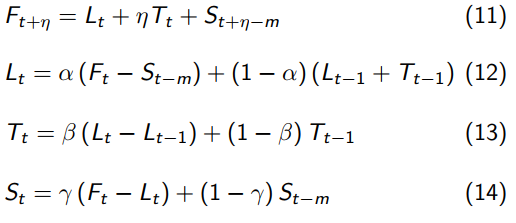



Multiplicativo  cuando la magnitud de los cambio de estacionalidad incrementan con el tiempo.
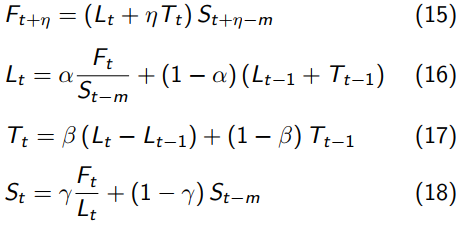
(HyndmanJ.Rob2002)

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pred1 = ExponentialSmoothing(np.asarray(train['Consumption']), trend='add', damped_trend=False, seasonal='add',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
pred2 = ExponentialSmoothing(np.asarray(train['Consumption']), trend='add', damped_trend=False, seasonal='mul',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters (A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('alpha: ', alpha_value)
beta_value = np.round(pred1.params['smoothing_trend'], 4)
print('beta: ', beta_value)
gamma_value = np.round(pred1.params['smoothing_seasonal'], 4)
print('gamma: ', gamma_value)
print('')

print('')
print('== Holt-Winters (A,M) Parameters ==')
print('')
alpha_value = np.round(pred2.params['smoothing_level'], 4)
print('alpha: ', alpha_value)
beta_value = np.round(pred2.params['smoothing_trend'], 4)
print('beta: ', beta_value)
gamma_value = np.round(pred2.params['smoothing_seasonal'], 4)
print('gamma: ', gamma_value)
print('')

### Forecast for next 16 months

y_pred1 =  pred1.forecast(steps = 16)
y_pred2 =  pred2.forecast(steps = 16)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['Consumption']})
df_pred2 = pd.DataFrame({'Y_hat':y_pred2,'Y':test['Consumption']})
print(df_pred1)
print(df_pred2)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(



== Holt-Winters (A,A) Parameters ==

alpha:  1.0
beta:  0.0
gamma:  0.0


== Holt-Winters (A,M) Parameters ==

alpha:  1.0
beta:  0.0
gamma:  0.0

       Y_hat        Y
35  2.193087  1.55221
36  1.696142  1.57034
37 -1.059051  1.08986
38 -1.911502  1.05821
39 -1.712360  1.39665
40 -1.551110  1.32161
41 -2.974147  0.96034
42 -2.518339  0.87553
43 -1.365208  1.07530
44 -1.015152  1.30285
45 -2.298785  0.88939
46 -2.445392  0.88818
47 -2.233895  0.99804
48 -2.730839  0.84120
49 -5.486033  0.74032
50 -6.338483  0.72823
       Y_hat        Y
35  1.739328  1.55221
36  1.262979  1.57034
37  0.672054  1.08986
38  0.373626  1.05821
39  0.128640  1.39665
40 -0.151278  1.32161
41 -0.368753  0.96034
42 -0.690723  0.87553
43 -1.253121  1.07530
44 -1.753072  1.30285
45 -1.926749  0.88939
46 -2.369081  0.88818
47 -2.934597  0.99804
48 -3.110202  0.84120
49 -2.598795  0.74032
50 -2.685512  0.72823


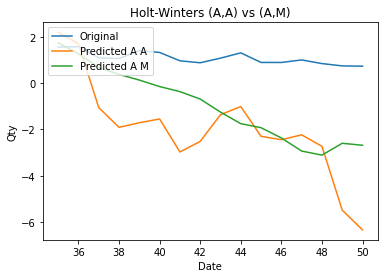

Para estacionalidad aditiva=  RMSE is 3.5646 MAPE is 292.53
Para estacionalidad multiplicativa=  RMSE is 2.4489 MAPE is 192.78


In [58]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted A A')
ax.plot(df_pred2.Y_hat, label='Predicted A M')

plt.legend(loc='upper left')
plt.title('Holt-Winters (A,A) vs (A,M)')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

rmse_add    =  np.sqrt(mean_squared_error(df_pred1.Y, df_pred1.Y_hat))
rmse_mul    =  np.sqrt(mean_squared_error(df_pred1.Y, df_pred2.Y_hat))
mape_add    =  MAPE(df_pred1.Y, df_pred1.Y_hat)
mape_mul    =  MAPE(df_pred1.Y, df_pred2.Y_hat)

print("Para estacionalidad aditiva=  RMSE is %3.4f MAPE is %3.2f" %(rmse_add, mape_add))
print("Para estacionalidad multiplicativa=  RMSE is %3.4f MAPE is %3.2f" %(rmse_mul, mape_mul))


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(



== Holt-Winters (M,A) Parameters ==

alpha:  1.0
beta:  0.0
gamma:  0.0


== Holt-Winters (M,M) Parameters ==

alpha:  1.0
beta:  0.0
gamma:  0.0

       Y_hat        Y
35  2.549551  1.55221
36  2.385400  1.57034
37  0.116006  1.08986
38 -0.282894  1.05821
39  0.339680  1.39665
40  0.896280  1.32161
41 -0.157679  0.96034
42  0.642694  0.87553
43  2.117503  1.07530
44  2.767916  1.30285
45  1.764694  0.88939
46  1.879874  0.88818
47  2.454588  0.99804
48  2.296742  0.84120
49  0.033234  0.74032
50 -0.360172  0.72823
       Y_hat        Y
35  2.021506  1.55221
36  1.785887  1.57034
37  1.280492  1.08986
38  1.144300  1.05821
39  1.185895  1.39665
40  1.159954  1.32161
41  0.930457  0.96034
42  0.999987  0.87553
43  1.235620  1.07530
44  1.280854  1.30285
45  1.090930  0.88939
46  1.075874  0.88818
47  1.097545  0.99804
48  0.969620  0.84120
49  0.695224  0.74032
50  0.621280  0.72823


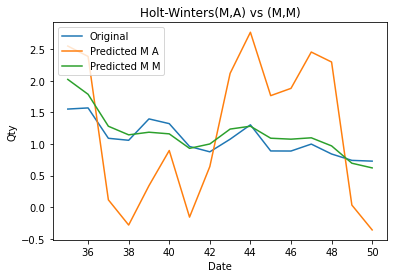

Para tendencia multiplicativa y estacionalidad aditiva=  RMSE is 1.0582 MAPE is 92.79
Para tendencia multiplicativa y estacionalidad multiplicativa=  RMSE is 0.1836 MAPE is 14.11


In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pred3 = ExponentialSmoothing(np.asarray(train['Consumption']), trend='mul', damped_trend=False, seasonal='add',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
pred4 = ExponentialSmoothing(np.asarray(train['Consumption']), trend='mul', damped_trend=False, seasonal='mul',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters (M,A) Parameters ==')
print('')
alpha_value = np.round(pred3.params['smoothing_level'], 4)
print('alpha: ', alpha_value)
beta_value = np.round(pred3.params['smoothing_trend'], 4)
print('beta: ', beta_value)
gamma_value = np.round(pred3.params['smoothing_seasonal'], 4)
print('gamma: ', gamma_value)
print('')

print('')
print('== Holt-Winters (M,M) Parameters ==')
print('')
alpha_value = np.round(pred4.params['smoothing_level'], 4)
print('alpha: ', alpha_value)
beta_value = np.round(pred4.params['smoothing_trend'], 4)
print('beta: ', beta_value)
gamma_value = np.round(pred4.params['smoothing_seasonal'], 4)
print('gamma: ', gamma_value)
print('')

### Forecast for next 16 months

y_pred3 =  pred3.forecast(steps = 16)
y_pred4 =  pred4.forecast(steps = 16)
df_pred3 = pd.DataFrame({'Y_hat':y_pred3,'Y':test['Consumption']})
df_pred4 = pd.DataFrame({'Y_hat':y_pred4,'Y':test['Consumption']})
print(df_pred3)
print(df_pred4)

### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred3.Y, label='Original')
ax.plot(df_pred3.Y_hat, label='Predicted M A')
ax.plot(df_pred4.Y_hat, label='Predicted M M')

plt.legend(loc='upper left')
plt.title('Holt-Winters(M,A) vs (M,M)')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

rmse_add    =  np.sqrt(mean_squared_error(df_pred3.Y, df_pred3.Y_hat))
rmse_mul    =  np.sqrt(mean_squared_error(df_pred3.Y, df_pred4.Y_hat))
mape_add    =  MAPE(df_pred3.Y, df_pred3.Y_hat)
mape_mul    =  MAPE(df_pred3.Y, df_pred4.Y_hat)

print("Para tendencia multiplicativa y estacionalidad aditiva=  RMSE is %3.4f MAPE is %3.2f" %(rmse_add, mape_add))
print("Para tendencia multiplicativa y estacionalidad multiplicativa=  RMSE is %3.4f MAPE is %3.2f" %(rmse_mul, mape_mul))


In [92]:
print(pred1.params)
print(pred2.params)
print(pred3.params)
print(pred4.params)

{'smoothing_level': 0.9999999850988388, 'smoothing_trend': 0.0, 'smoothing_seasonal': 8.596822110020921e-10, 'damping_trend': nan, 'initial_level': 12.876160864155597, 'initial_trend': -0.3689151412686547, 'initial_seasons': array([ 2.47075046,  0.08447189, -0.39906353,  0.16899341,  0.69915867,
       -0.35496335,  0.46975938,  1.99180559,  2.7107775 ,  1.79605934,
        2.01836772,  2.59877999]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.9999999850988388, 'smoothing_trend': 0.0, 'smoothing_seasonal': 2.7830894016559434e-12, 'damping_trend': nan, 'initial_level': 9.197410137013643, 'initial_trend': -0.21846664846924102, 'initial_seasons': array([1.66813459, 1.24765388, 1.16689735, 1.26464163, 1.2957872 ,
       1.10005618, 1.24751466, 1.62290632, 1.76968435, 1.59356691,
       1.6595482 , 1.78285218]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.9999999850988388, 'smoothing_trend': 0.0, 'smoothing_seasonal': 2

In [60]:
path = os.path.join('c:' + os.sep, 'Users', 'Christian Galicia', 'Desktop', 'Christian', 'Doctorado', 'HoltWinters', 'AirPax.csv')
AirPax =  pd.read_csv(path)
date_rng = pd.date_range(start='1/1/1949', end='31/12/1960', freq='M')
print(date_rng)

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')



 Training data start at 

   Year Month  Passenger  TimeIndex
0  1949   Jan        112 1949-01-31 ['Year', 'Month']

 Training data ends at 

    Year Month  Passenger  TimeIndex
99  1957   Apr        348 1957-04-30 ['Year', 'Month']

 Test data start at 

     Year Month  Passenger  TimeIndex
100  1957   May        355 1957-05-31 ['Year', 'Month']

 Test data ends at 

     Year Month  Passenger  TimeIndex
143  1960   Dec        432 1960-12-31 ['Year', 'Month']


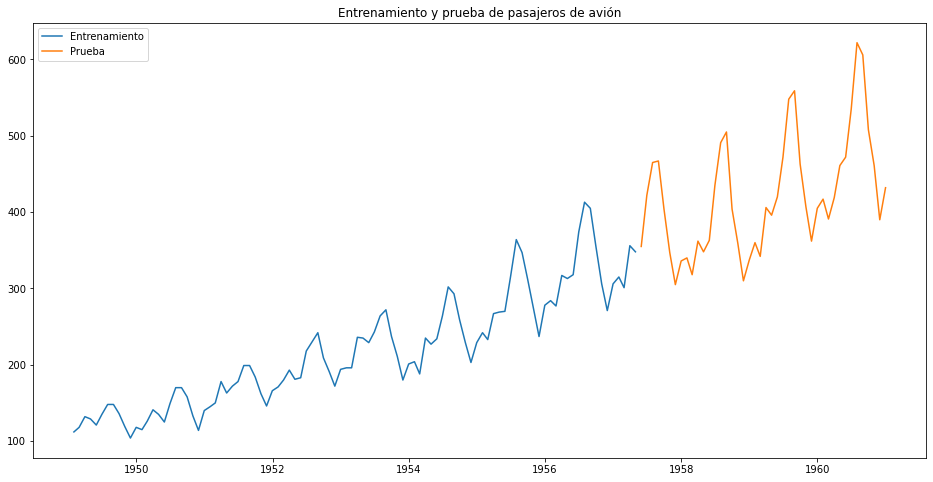

In [61]:
AirPax['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])

train = AirPax[0:int(len(AirPax)*0.7)] 
test= AirPax[int(len(AirPax)*0.7):]

print("\n Training data start at \n")
print (train[train.TimeIndex == train.TimeIndex.min()],['Year','Month'])
print("\n Training data ends at \n")
print (train[train.TimeIndex == train.TimeIndex.max()],['Year','Month'])

print("\n Test data start at \n")
print (test[test.TimeIndex == test.TimeIndex.min()],['Year','Month'])

print("\n Test data ends at \n")
print (test[test.TimeIndex == test.TimeIndex.max()],['Year','Month'])

plt.figure(figsize=(16,8))
plt.plot(train.TimeIndex, train.Passenger, label = 'Entrenamiento')
plt.plot(test.TimeIndex, test.Passenger,  label = 'Prueba')
plt.legend(loc = 'best')
plt.title('Entrenamiento y prueba de pasajeros de avión')
plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


{'smoothing_level': 0.25502710168632864, 'smoothing_trend': 2.7234371087205906e-11, 'smoothing_seasonal': 0.7449728982406136, 'damping_trend': nan, 'initial_level': 190.50487011347292, 'initial_trend': 2.3251526618816505, 'initial_seasons': array([ -80.83007618,  -75.2270477 ,  -62.74885834,  -68.01980486,
        -76.78051245,  -62.67765499,  -50.4627566 ,  -52.88954049,
        -67.0229485 ,  -85.82887485, -100.27066804,  -83.66038869]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.7295545438414219, 'smoothing_trend': 8.428592436418804e-06, 'smoothing_seasonal': 1.8829024095309143e-06, 'damping_trend': nan, 'initial_level': 142.97061514863444, 'initial_trend': 2.626629819317527, 'initial_seasons': array([0.77853132, 0.7560588 , 0.87188163, 0.84348751, 0.83735972,
       0.94462009, 1.04391505, 1.02157817, 0.89783331, 0.77991487,
       0.6777969 , 0.76625699]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.235070722

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


{'smoothing_level': 0.6846523800684149, 'smoothing_trend': 4.803421505203777e-09, 'smoothing_seasonal': 1.4196680713434245e-09, 'damping_trend': nan, 'initial_level': 157.75423178482168, 'initial_trend': 1.0102119529601425, 'initial_seasons': array([0.71456589, 0.69389151, 0.79999696, 0.77376189, 0.7688933 ,
       0.86747654, 0.95859189, 0.93788597, 0.82418852, 0.71604231,
       0.62252192, 0.70360379]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


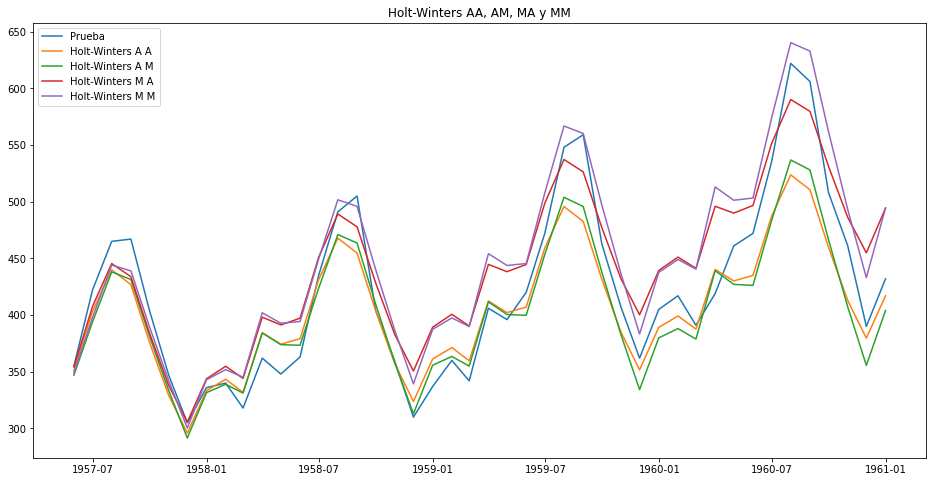

In [68]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pred1 = ExponentialSmoothing(np.asarray(train['Passenger']), trend='add', damped_trend=False, seasonal_periods=12 ,seasonal='add').fit(optimized=True)

print(pred1.params)

pred2 = ExponentialSmoothing(np.asarray(train['Passenger']), trend='add', damped_trend=False, seasonal_periods=12 ,seasonal='mul').fit(optimized=True)

print(pred2.params)

pred3 = ExponentialSmoothing(np.asarray(train['Passenger']), trend='mul', damped_trend=False, seasonal_periods=12 ,seasonal='add').fit(optimized=True)

print(pred3.params)

pred4 = ExponentialSmoothing(np.asarray(train['Passenger']), trend='mul', damped_trend=False, seasonal_periods=12 ,seasonal='mul').fit(optimized=True)

print(pred4.params)

pred_HoltW1 = test.copy()
pred_HoltW2 = test.copy()
pred_HoltW4 = test.copy()
pred_HoltW3 = test.copy()
pred_HoltW1['HoltW1'] = pred1.forecast(len(test['Passenger']))
pred_HoltW2['HoltW2'] = pred2.forecast(len(test['Passenger']))
pred_HoltW3['HoltW3'] = pred3.forecast(len(test['Passenger']))
pred_HoltW4['HoltW4'] = pred4.forecast(len(test['Passenger']))

plt.figure(figsize=(16,8))
#plt.plot(train.TimeIndex, train['Passenger'], label='Entrenamiento')
plt.plot(test.TimeIndex, test['Passenger'], label='Prueba')
plt.plot(test.TimeIndex, pred_HoltW1['HoltW1'], label='Holt-Winters A A')
plt.plot(test.TimeIndex, pred_HoltW2['HoltW2'], label='Holt-Winters A M')
plt.plot(test.TimeIndex, pred_HoltW3['HoltW3'], label='Holt-Winters M A')
plt.plot(test.TimeIndex, pred_HoltW4['HoltW4'], label='Holt-Winters M M')
plt.title('Holt-Winters AA, AM, MA y MM' )
plt.legend(loc='best')
plt.show()


In [63]:
df_pred_opt1 =  pd.DataFrame({'Y_hat':pred_HoltW1['HoltW1'] ,'Y':test['Passenger'].values})
df_pred_opt2 =  pd.DataFrame({'Y_hat':pred_HoltW2['HoltW2'] ,'Y':test['Passenger'].values})
df_pred_opt3 =  pd.DataFrame({'Y_hat':pred_HoltW3['HoltW3'] ,'Y':test['Passenger'].values})
df_pred_opt4 =  pd.DataFrame({'Y_hat':pred_HoltW4['HoltW4'] ,'Y':test['Passenger'].values})

rmse_opt_AA    =  np.sqrt(mean_squared_error(df_pred_opt1.Y, df_pred_opt1.Y_hat))
rmse_opt_AM    =  np.sqrt(mean_squared_error(df_pred_opt2.Y, df_pred_opt2.Y_hat))
rmse_opt_MA    =  np.sqrt(mean_squared_error(df_pred_opt3.Y, df_pred_opt3.Y_hat))
rmse_opt_MM    =  np.sqrt(mean_squared_error(df_pred_opt4.Y, df_pred_opt4.Y_hat))
mape_opt_AA    =  MAPE(df_pred_opt1.Y, df_pred_opt1.Y_hat)
mape_opt_AM    =  MAPE(df_pred_opt2.Y, df_pred_opt2.Y_hat)
mape_opt_MA    =  MAPE(df_pred_opt3.Y, df_pred_opt3.Y_hat)
mape_opt_MM    =  MAPE(df_pred_opt4.Y, df_pred_opt4.Y_hat)
print("HW-AA RMSE and MAPE")
print(rmse_opt_AA, mape_opt_AA)
print("HW-AM RMSE and MAPE")
print(rmse_opt_AM, mape_opt_AM)
print("HW-MA RMSE and MAPE")
print(rmse_opt_MA, mape_opt_MA)
print("HW-MM RMSE and MAPE")
print(rmse_opt_MM, mape_opt_MM)

HW-AA RMSE and MAPE
33.628654748322695 5.91
HW-AM RMSE and MAPE
31.854818504148202 6.02
HW-MA RMSE and MAPE
33.5591447665485 6.95
HW-MM RMSE and MAPE
35.26041280348297 7.26


[1]Palit, A. K., Popovic, D., & Applications, E. (2006). Computational Intelligence in Time Series Forecasting. In Technometrics (Vol. 48, Issue 3). https://doi.org/10.1198/tech.2006.s423    
[2] Svetunkov, I., & Kourentzes, N. (2015). Complex Exponential Smoothing. 31. https://ideas.repec.org/p/pra/mprapa/69394.html             
[3] de Livera, A. M., Hyndman, R. J., & Snyder, R. D. (2011). Forecasting time series with complex seasonal patterns using exponential smoothing. Journal of the American Statistical Association, 106(496), 1513–1527. https://doi.org/10.1198/jasa.2011.tm09771                                              
[4] Hyndman J. Rob, Anne, K. B., Ralph, S. D., & Simone, G. (2002). A state space framework for automatic forecasting using exponential smoothing methods. International Journal of Forecasting, 18(3), 439–454.                             
[5] Hyndman, R. J., & Khandakar, Y. (2008). Automatic time series forecasting: The forecast package for R. Journal of Statistical Software, 27(3), 1–22. https://doi.org/10.18637/jss.v027.i03